In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.signal import resample
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Load datasets
eeg_data = pd.read_csv('eeg_data_trimmed.csv')
emg_data = pd.read_csv('emg_data_trimmed.csv')
labels = pd.read_csv('labels_trimmed.csv')

# Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels.values.ravel())

# Resample EEG to match EMG's length (if necessary)
if len(eeg_data) != len(emg_data):
    eeg_data = resample(eeg_data, num=len(emg_data))

# Dynamic Time Warping (DTW) for offline alignment
distance, path = fastdtw(eeg_data.values, emg_data.values, dist=euclidean)
aligned_eeg = eeg_data.iloc[[p[0] for p in path]]
aligned_emg = emg_data.iloc[[p[1] for p in path]]

# Combine aligned data
combined_data = pd.concat([aligned_eeg.reset_index(drop=True), aligned_emg.reset_index(drop=True)], axis=1)

# Add noise to the input data
noise_factor = 0.1  # Adjust noise level
combined_data += noise_factor * np.random.normal(size=combined_data.shape)

# Randomly flip a percentage of labels
label_flip_percentage = 0.1  # 10% label noise
num_flips = int(len(labels) * label_flip_percentage)
flip_indices = np.random.choice(len(labels), size=num_flips, replace=False)
labels[flip_indices] = np.random.choice(np.unique(labels), size=num_flips)

# Define a custom Dataset
class EEGEMGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Model Definitions (unchanged from earlier code)
class ShallowConvNet(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ShallowConvNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.fc = nn.Linear(16 * ((input_dim - 2) // 2), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if x.dim() == 2:  # Reshape if input is flat
            x = x.unsqueeze(1)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.squeeze(0)
        return self.fc(h_n)

class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        if x.dim() == 2:  # Reshape if input is flat
            x = x.unsqueeze(1)
        _, h_n = self.gru(x)
        h_n = h_n.squeeze(0)
        return self.fc(h_n)

class CNNLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(CNNLSTMNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(16, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.squeeze(0)
        return self.fc(h_n)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes):
        super(VAE, self).__init__()
        self.encoder = nn.Linear(input_dim, latent_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        self.fc = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        z = torch.relu(self.encoder(x.view(x.size(0), -1)))
        x_recon = torch.sigmoid(self.decoder(z))
        logits = self.fc(z)
        return logits, x_recon


# Train and Evaluate Models
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
model_classes = {
    "ShallowConvNet": ShallowConvNet,
    "LSTMNet": LSTMNet,
    "GRUNet": GRUNet,
    "CNNLSTMNet": CNNLSTMNet,
    "VAE": VAE,
}
results = {name: [] for name in model_classes.keys()}
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Evaluation function with Confusion Matrix
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            if isinstance(model, VAE):
                logits, _ = model(X_batch)  # VAE returns two outputs
            else:
                logits = model(X_batch)  # Other models return single output

            _, predicted = torch.max(logits, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print("\nEvaluation Metrics:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", conf_matrix)

    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}

# Online Adaptation with Regularization
def online_adaptation_with_regularization(
    model, optimizer, buffer_X, buffer_y, criterion, val_loader, num_cycles=3, batch_size=16, lr=0.0001
):
    model.train()
    buffer_dataset = EEGEMGDataset(buffer_X, buffer_y)
    buffer_loader = DataLoader(buffer_dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.005)

    for cycle in range(num_cycles):
        print(f"\nOnline Adaptation Cycle {cycle + 1}/{num_cycles}")
        for X_batch, y_batch in buffer_loader:
            optimizer.zero_grad()

            # Handle VAE separately because it returns (logits, x_recon)
            if isinstance(model, VAE):
                outputs, _ = model(X_batch)  # Extract only logits
            else:
                outputs = model(X_batch)  # Other models return only logits
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

        # Evaluate after each adaptation cycle
        print("\nValidation Metrics After Online Adaptation Cycle:")
        evaluate_model(model, val_loader)

online_adaptation_percentage = 0.3  # 30% data for online adaptation

# Training and Evaluation Loop with Online Adaptation
epochs = 10  # Define number of training epochs

for fold, (train_index, val_index) in enumerate(kf.split(combined_data)):
    print(f"\nFold {fold + 1}/{k}")

    X_train, X_val = combined_data.values[train_index], combined_data.values[val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Define model parameters
    input_dim = X_train.shape[1]  # Define input dimension dynamically
    hidden_dim = 256  # Define hidden_dim for LSTM, GRU, CNN-LSTM
    latent_dim = 64  # Define latent dimension for VAE
    num_classes = len(np.unique(labels))

    # Split part of training data for online adaptation
    split_idx = int(len(X_train) * online_adaptation_percentage)
    buffer_X, X_train = X_train[:split_idx], X_train[split_idx:]
    buffer_y, y_train = y_train[:split_idx], y_train[split_idx:]

    train_dataset = EEGEMGDataset(X_train, y_train)
    val_dataset = EEGEMGDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    for model_name, ModelClass in model_classes.items():
        print(f"\nTraining {model_name} on Fold {fold + 1}")

        # Define model architecture properly
        if model_name == "VAE":
            model = ModelClass(input_dim=input_dim, latent_dim=latent_dim, num_classes=num_classes)
        elif model_name == "ShallowConvNet":
            model = ModelClass(input_dim=input_dim, num_classes=num_classes)
        else:  # LSTM, GRU, CNN-LSTM need hidden_dim
            model = ModelClass(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        for epoch in range(epochs):
            model.train()
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()

                if model_name == "VAE":
                    logits, _ = model(X_batch)  # VAE returns both logits and reconstructions
                else:
                    logits = model(X_batch)  # Other models only return logits

                loss = criterion(logits, y_batch)
                loss.backward()
                optimizer.step()

        print("\nValidation Metrics Before Online Adaptation:")
        metrics = evaluate_model(model, val_loader)
        results[model_name].append(metrics)

        # Save trained model for the fold
        torch.save(model.state_dict(), f"{model_name}_fold{fold + 1}.pth")
        print(f"Saved {model_name} for Fold {fold + 1}")

        # Perform online adaptation
        print(f"\nStarting Online Adaptation for {model_name} on Fold {fold + 1}...")
        online_adaptation_with_regularization(model, optimizer, buffer_X, buffer_y, criterion, val_loader)

# Compute Average Metrics
for model_name in results:
    avg_metrics = {metric: np.mean([fold[metric] for fold in results[model_name]]) for metric in results[model_name][0]}
    print(f"\n{model_name} - Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric.capitalize()}: {value:.2f}")



Fold 1/5

Training ShallowConvNet on Fold 1

Validation Metrics Before Online Adaptation:

Evaluation Metrics:
Precision: 0.5058, Recall: 0.6171, F1-Score: 0.5372, Accuracy: 0.6171
Confusion Matrix:
 [[  0   0  33 161   8   2   7]
 [  0   0  40 162   0   3   1]
 [  0   0 161   6   2   1   2]
 [  0   0   0 164  10   1   0]
 [  0   0   4  18 156   2   5]
 [  0   0   7   8   2 177   2]
 [  0   0   3  10   3   4 159]]
Saved ShallowConvNet for Fold 1

Starting Online Adaptation for ShallowConvNet on Fold 1...

Online Adaptation Cycle 1/3

Validation Metrics After Online Adaptation Cycle:

Evaluation Metrics:
Precision: 0.5040, Recall: 0.5098, F1-Score: 0.4479, Accuracy: 0.5098
Confusion Matrix:
 [[188  16   3   0   1   3   0]
 [ 10 192   1   0   0   3   0]
 [ 33  44  92   0   1   2   0]
 [ 17 156   0   0   1   1   0]
 [ 41  84   1   0  53   6   0]
 [  4  37   5   0   0 150   0]
 [ 15 140   0   0   3  21   0]]

Online Adaptation Cycle 2/3

Validation Metrics After Online Adaptation Cycle:



In [3]:
from sklearn.metrics import cohen_kappa_score
import torch

# Function to compute Cohen's Kappa Score
def compute_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred)

# Load saved model and evaluate
def evaluate_trained_model(model, model_path, val_loader):
    model.load_state_dict(torch.load(model_path))  # Load trained weights
    model.eval()

    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            if isinstance(model, VAE):
                logits, _ = model(X_batch)  # VAE returns two outputs
            else:
                logits = model(X_batch)  # Other models return single output

            _, predicted = torch.max(logits, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    kappa = compute_kappa(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print("\nEvaluation Metrics:")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print("Confusion Matrix:\n", conf_matrix)

    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy, 'kappa': kappa}

# Load trained models and compute Kappa score
for model_name, ModelClass in model_classes.items():
    print(f"\nEvaluating {model_name}...")
    
    # Initialize model
    if model_name == "VAE":
        model = ModelClass(input_dim=input_dim, latent_dim=latent_dim, num_classes=num_classes)
    elif model_name == "ShallowConvNet":
        model = ModelClass(input_dim=input_dim, num_classes=num_classes)
    else:
        model = ModelClass(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes)

    # Load trained model and evaluate
    model_path = f"{model_name}_fold1.pth"  # Change fold number if needed
    evaluate_trained_model(model, model_path, val_loader)



Evaluating ShallowConvNet...

Evaluation Metrics:
Precision: 0.6901, Recall: 0.6858, F1-Score: 0.6140, Accuracy: 0.6858
Cohen's Kappa: 0.6295
Confusion Matrix:
 [[  6   0  34 116   0   0   5]
 [  0   0  34 140   1   1   2]
 [  0   0 180   9   0   1   3]
 [  0   0   4 201   3   4   4]
 [  0   0   6   9 163   0   4]
 [  0   0   6   7   0 183   5]
 [  0   0   6   4   3   5 175]]

Evaluating LSTMNet...

Evaluation Metrics:
Precision: 0.5796, Recall: 0.6624, F1-Score: 0.5994, Accuracy: 0.6624
Cohen's Kappa: 0.6035
Confusion Matrix:
 [[  0   0 149   2   0   2   8]
 [  0   0 171   3   1   1   2]
 [  0   0 184   3   2   1   3]
 [  0   0   9 189  10   5   3]
 [  0   0  13   7 149   0  13]
 [  0   0   8   5   0 184   4]
 [  0   0   7   3   3   9 171]]

Evaluating GRUNet...


/tmp/ipykernel_255550/1817992428.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load trained weights
/tmp/ipykernel_25


Evaluation Metrics:
Precision: 0.5834, Recall: 0.6654, F1-Score: 0.6025, Accuracy: 0.6654
Cohen's Kappa: 0.6071
Confusion Matrix:
 [[  0   0 149   2   0   2   8]
 [  0   0 171   3   1   1   2]
 [  0   0 184   3   2   1   3]
 [  0   0   9 189  10   5   3]
 [  0   0  13   6 148   0  15]
 [  0   0   8   5   0 183   5]
 [  0   0   7   3   3   3 177]]

Evaluating CNNLSTMNet...


/tmp/ipykernel_255550/1817992428.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load trained weights



Evaluation Metrics:
Precision: 0.4569, Recall: 0.5257, F1-Score: 0.4556, Accuracy: 0.5257
Cohen's Kappa: 0.4422
Confusion Matrix:
 [[  0   0 149   2   0   4   6]
 [  0   0 171   4   0   1   2]
 [  0   0 184   5   0   1   3]
 [  0   0   9 190   8   4   5]
 [  0   0  13  53  71  33  12]
 [  0   0   8   5   1 116  71]
 [  0   0   7   4   2  45 135]]

Evaluating VAE...

Evaluation Metrics:
Precision: 0.5832, Recall: 0.6662, F1-Score: 0.6031, Accuracy: 0.6662
Cohen's Kappa: 0.6080
Confusion Matrix:
 [[  0   0 149   1   1   2   8]
 [  0   0 170   4   1   1   2]
 [  0   0 184   2   3   1   3]
 [  0   0   9 189  10   5   3]
 [  0   0  13   2 152   0  15]
 [  0   0   8   5   0 184   4]
 [  0   0   7   3   3   7 173]]


/tmp/ipykernel_255550/1817992428.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))  # Load trained weights


In [1]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, cohen_kappa_score
from scipy.signal import resample

# Load datasets
eeg_data = pd.read_csv('eeg_data_trimmed.csv')
emg_data = pd.read_csv('emg_data_trimmed.csv')
labels = pd.read_csv('labels_trimmed.csv')

# Label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels.values.ravel())

# Resample EEG to match EMG's length (if necessary)
if len(eeg_data) != len(emg_data):
    eeg_data = resample(eeg_data, num=len(emg_data))

# Combine data
data = np.concatenate([eeg_data.values, emg_data.values], axis=1)

# Define a custom Dataset
class EEGEMGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
# CNN-GRU model
class EEGEMGCNNGRU(nn.Module):
    def __init__(self, input_dim_eeg, input_dim_emg, num_classes):
        super(EEGEMGCNNGRU, self).__init__()
        
        # EEG CNN Branch
        self.eeg_cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # EMG CNN Branch
        self.emg_cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # GRU layers
        self.eeg_gru = nn.GRU(input_size=32, hidden_size=64, num_layers=2, batch_first=True, dropout=0.5)
        self.emg_gru = nn.GRU(input_size=32, hidden_size=64, num_layers=2, batch_first=True, dropout=0.5)

        # Fully connected layers after feature fusion
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, eeg, emg):
        eeg_features = self.eeg_cnn(eeg).transpose(1, 2)  # Prepare for GRU
        emg_features = self.emg_cnn(emg).transpose(1, 2)  # Prepare for GRU
        
        _, eeg_hidden = self.eeg_gru(eeg_features)
        _, emg_hidden = self.emg_gru(emg_features)
        
        eeg_last_hidden = eeg_hidden[-1]  # Last GRU layer output
        emg_last_hidden = emg_hidden[-1]  # Last GRU layer output
        
        fused_features = torch.cat((eeg_last_hidden, emg_last_hidden), dim=1)
        
        # Classification
        output = self.fc(fused_features)
        return output

# CNN-RNN model
class EEGEMGCNNRNN(nn.Module):
    def __init__(self, input_dim_eeg, input_dim_emg, num_classes):
        super(EEGEMGCNNRNN, self).__init__()
        
        # EEG CNN Branch
        self.eeg_cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # EMG CNN Branch
        self.emg_cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # RNN layers
        self.eeg_rnn = nn.RNN(input_size=32, hidden_size=64, num_layers=2, batch_first=True, dropout=0.5)
        self.emg_rnn = nn.RNN(input_size=32, hidden_size=64, num_layers=2, batch_first=True, dropout=0.5)

        # Fully connected layers after feature fusion
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, eeg, emg):
        eeg_features = self.eeg_cnn(eeg).transpose(1, 2)  # Prepare for RNN
        emg_features = self.emg_cnn(emg).transpose(1, 2)  # Prepare for RNN
        
        _, eeg_hidden = self.eeg_rnn(eeg_features)
        _, emg_hidden = self.emg_rnn(emg_features)
        
        eeg_last_hidden = eeg_hidden[-1]  # Last RNN layer output
        emg_last_hidden = emg_hidden[-1]  # Last RNN layer output
        
        fused_features = torch.cat((eeg_last_hidden, emg_last_hidden), dim=1)
        
        # Classification
        output = self.fc(fused_features)
        return output

# Temporal Convolutional Network (TCN)
class EEGEMGTCN(nn.Module):
    def __init__(self, input_dim_eeg, input_dim_emg, num_classes):
        super(EEGEMGTCN, self).__init__()
        
        # TCN for EEG
        self.eeg_tcn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, dilation=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, dilation=2, padding=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, dilation=4, padding=8),
            nn.ReLU()
        )
        
        # TCN for EMG
        self.emg_tcn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, dilation=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, dilation=2, padding=4),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, dilation=4, padding=8),
            nn.ReLU()
        )
        
        # Fully connected layers after feature fusion
        self.fc = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, eeg, emg):
        eeg_features = self.eeg_tcn(eeg).mean(dim=2)  # Global average pooling
        emg_features = self.emg_tcn(emg).mean(dim=2)  # Global average pooling
        
        fused_features = torch.cat((eeg_features, emg_features), dim=1)
        
        # Classification
        output = self.fc(fused_features)
        return output

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Fold 1/5
Epoch 1/25, Loss: 1.9048, Val Loss: 1.4176
Epoch 2/25, Loss: 1.3110, Val Loss: 1.2671
Epoch 3/25, Loss: 1.2791, Val Loss: 1.2614
Epoch 4/25, Loss: 1.1890, Val Loss: 1.1050
Epoch 5/25, Loss: 1.1581, Val Loss: 1.0295
Epoch 6/25, Loss: 1.2122, Val Loss: 1.0161
Epoch 7/25, Loss: 1.1480, Val Loss: 1.0361
Epoch 8/25, Loss: 0.9884, Val Loss: 0.9995
Epoch 9/25, Loss: 0.9498, Val Loss: 1.0216
Epoch 10/25, Loss: 1.2433, Val Loss: 1.3658
Epoch 11/25, Loss: 1.3580, Val Loss: 1.2806
Epoch 12/25, Loss: 1.1530, Val Loss: 0.9881
Epoch 13/25, Loss: 0.9721, Val Loss: 0.9203
Epoch 14/25, Loss: 0.9302, Val Loss: 0.8972
Epoch 15/25, Loss: 0.9201, Val Loss: 0.8893
Epoch 16/25, Loss: 0.9110, Val Loss: 0.8751
Epoch 17/25, Loss: 0.9038, Val Loss: 0.8801
Epoch 18/25, Loss: 0.8941, Val Loss: 0.8744
Epoch 19/25, Loss: 0.8789, Val Loss: 0.8528
Epoch 20/25, Loss: 0.8800, Val Loss: 0.8510
Epoch 21/25, Loss: 0.8796, Val Loss: 0.8146
Epoch 22/25, Loss: 0.7881, Val Loss: 0.7276
Epoch 23/25, Loss: 0.7728, Val L

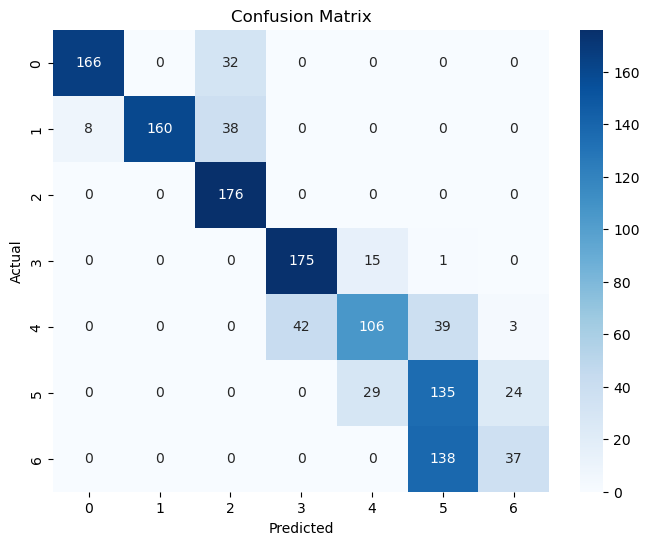


Starting Online Adaptation...


Online Adaptation Cycle 1/3


/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.46
Precision: 0.32
Recall: 0.46
F1 Score: 0.37
Cohen’s Kappa: 0.37


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


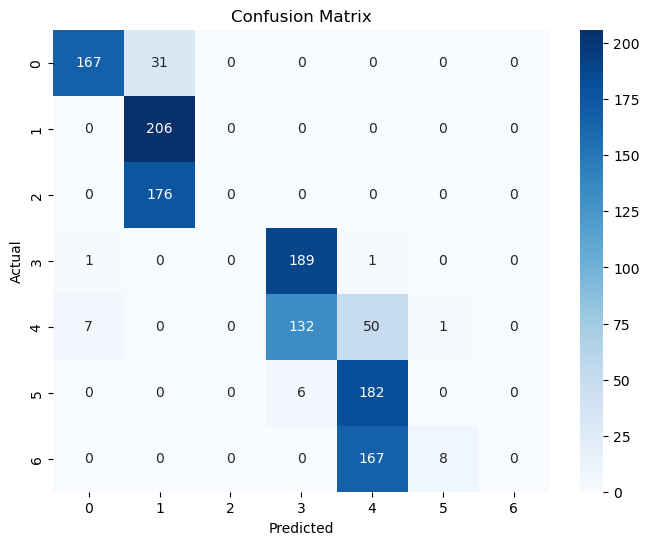


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.44
Precision: 0.28
Recall: 0.44
F1 Score: 0.31
Cohen’s Kappa: 0.34


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


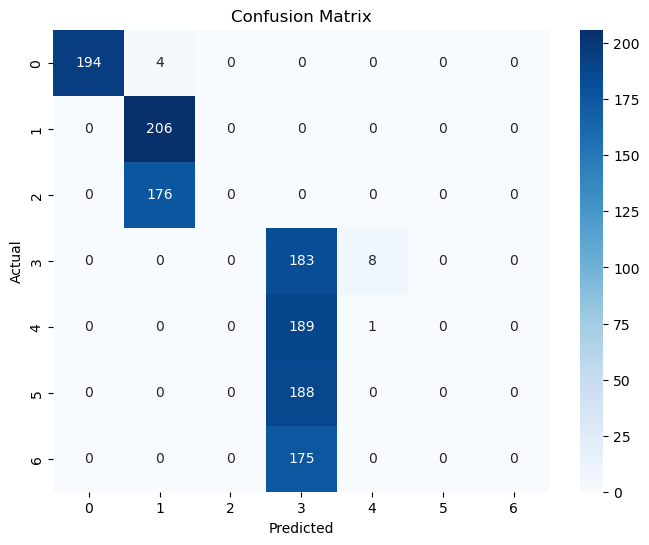


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.31
Precision: 0.16
Recall: 0.31
F1 Score: 0.20
Cohen’s Kappa: 0.19


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Metrics:
Accuracy: 0.31
Precision: 0.16
Recall: 0.31
F1 Score: 0.20
Cohen’s Kappa: 0.19


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/5
Epoch 1/25, Loss: 1.6788, Val Loss: 1.2926
Epoch 2/25, Loss: 1.2976, Val Loss: 1.2684
Epoch 3/25, Loss: 1.2821, Val Loss: 1.2623
Epoch 4/25, Loss: 1.2664, Val Loss: 1.2048
Epoch 5/25, Loss: 1.1704, Val Loss: 0.9932
Epoch 6/25, Loss: 1.0885, Val Loss: 1.0586
Epoch 7/25, Loss: 1.1214, Val Loss: 1.5709
Epoch 8/25, Loss: 1.1161, Val Loss: 1.1123
Epoch 9/25, Loss: 1.0011, Val Loss: 0.9059
Epoch 10/25, Loss: 0.9093, Val Loss: 0.8592
Epoch 11/25, Loss: 0.8985, Val Loss: 0.8451
Epoch 12/25, Loss: 0.8891, Val Loss: 0.8313
Epoch 13/25, Loss: 0.8754, Val Loss: 0.8315
Epoch 14/25, Loss: 0.8964, Val Loss: 0.8828
Epoch 15/25, Loss: 0.8792, Val Loss: 0.8265
Epoch 16/25, Loss: 0.9220, Val Loss: 0.9026
Epoch 17/25, Loss: 0.9180, Val Loss: 0.8828
Epoch 18/25, Loss: 0.8895, Val Loss: 0.8103
Epoch 19/25, Loss: 0.8202, Val Loss: 0.6026
Epoch 20/25, Loss: 1.0124, Val Loss: 0.6614
Epoch 21/25, Loss: 0.7234, Val Loss: 0.5866
Epoch 22/25, Loss: 0.7487, Val Loss: 0.5812
Epoch 23/25, Loss: 0.8629, Val L

/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.58
Precision: 0.48
Recall: 0.58
F1 Score: 0.50
Cohen’s Kappa: 0.51


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.58
Precision: 0.48
Recall: 0.58
F1 Score: 0.50
Cohen’s Kappa: 0.51


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


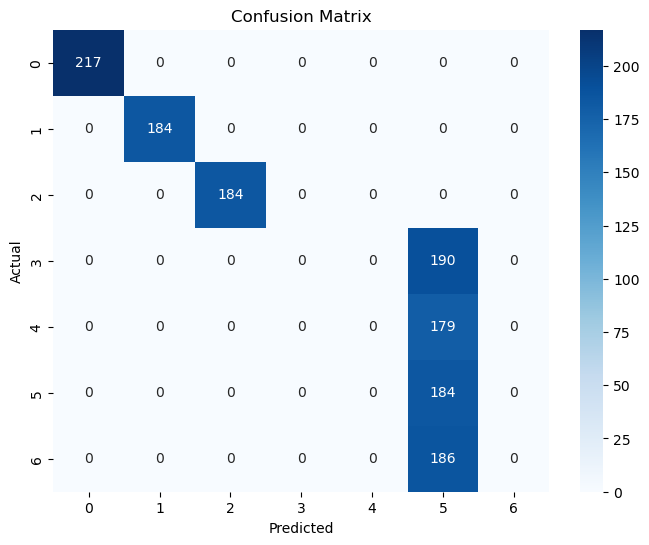


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.58
Precision: 0.48
Recall: 0.58
F1 Score: 0.50
Cohen’s Kappa: 0.51


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


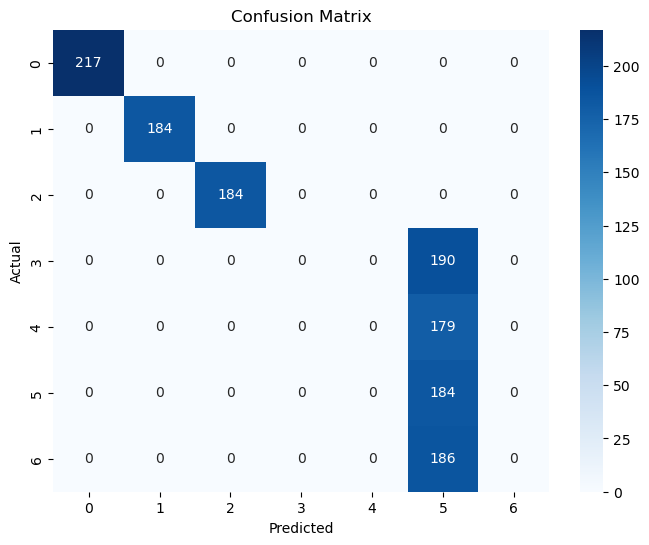


Evaluation Metrics:
Accuracy: 0.58
Precision: 0.48
Recall: 0.58
F1 Score: 0.50
Cohen’s Kappa: 0.51


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


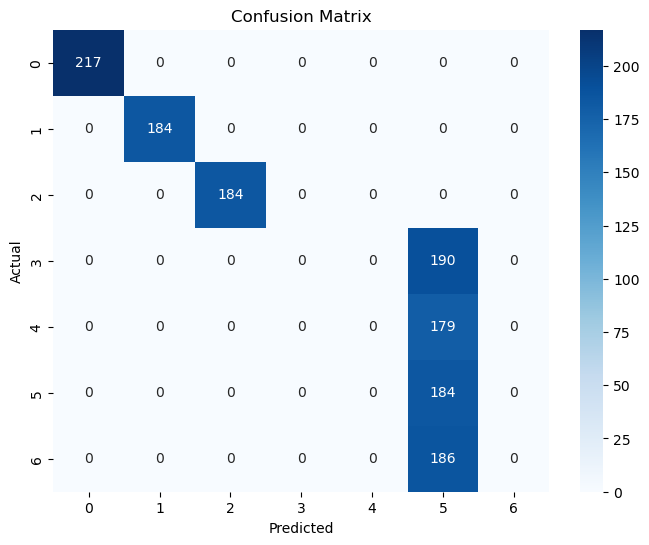

Fold 3/5
Epoch 1/25, Loss: 1.6075, Val Loss: 1.2856
Epoch 2/25, Loss: 1.2968, Val Loss: 1.2633
Epoch 3/25, Loss: 1.2565, Val Loss: 1.2709
Epoch 4/25, Loss: 1.2843, Val Loss: 1.2708
Epoch 5/25, Loss: 1.2767, Val Loss: 1.2750
Epoch 6/25, Loss: 1.2742, Val Loss: 1.2734
Epoch 7/25, Loss: 1.2509, Val Loss: 1.4971
Early stopping triggered.

Evaluation Before Online Adaptation:

Evaluation Metrics:
Accuracy: 0.26
Precision: 0.08
Recall: 0.26
F1 Score: 0.12
Cohen’s Kappa: 0.14


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


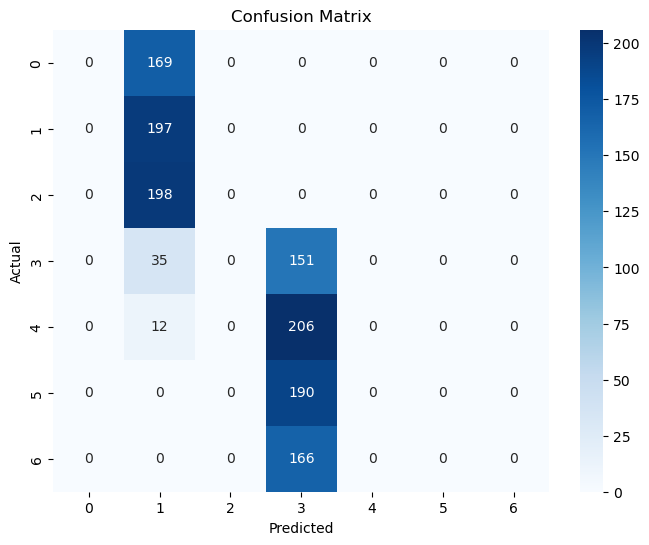

/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.19
Precision: 0.09
Recall: 0.19
F1 Score: 0.09
Cohen’s Kappa: 0.05


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


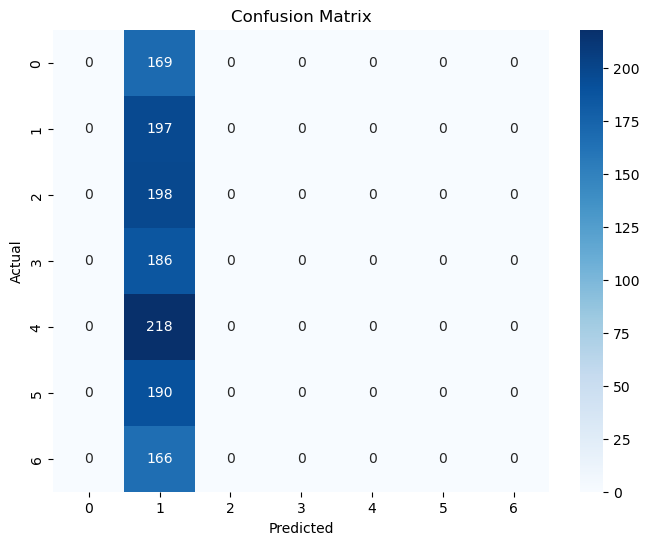


Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


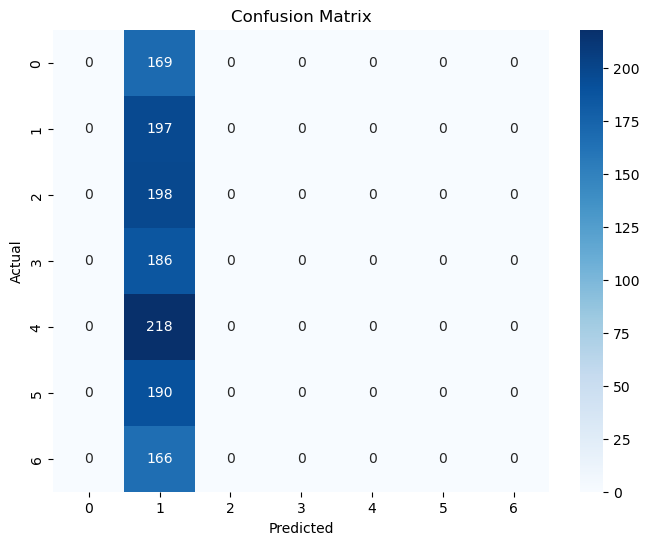

Fold 4/5
Epoch 1/25, Loss: 1.6073, Val Loss: 1.2732
Epoch 2/25, Loss: 1.2946, Val Loss: 1.2689
Epoch 3/25, Loss: 1.2789, Val Loss: 1.2631
Epoch 4/25, Loss: 1.2685, Val Loss: 1.2342
Epoch 5/25, Loss: 1.2653, Val Loss: 1.1687
Epoch 6/25, Loss: 1.2418, Val Loss: 1.6709
Epoch 7/25, Loss: 1.2111, Val Loss: 0.9735
Epoch 8/25, Loss: 0.9491, Val Loss: 0.7505
Epoch 9/25, Loss: 1.0168, Val Loss: 0.9547
Epoch 10/25, Loss: 0.9237, Val Loss: 0.8213
Epoch 11/25, Loss: 0.8452, Val Loss: 0.7962
Epoch 12/25, Loss: 0.8246, Val Loss: 0.7968
Epoch 13/25, Loss: 0.8211, Val Loss: 0.7896
Early stopping triggered.

Evaluation Before Online Adaptation:

Evaluation Metrics:
Accuracy: 0.58
Precision: 0.48
Recall: 0.58
F1 Score: 0.50
Cohen’s Kappa: 0.51


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


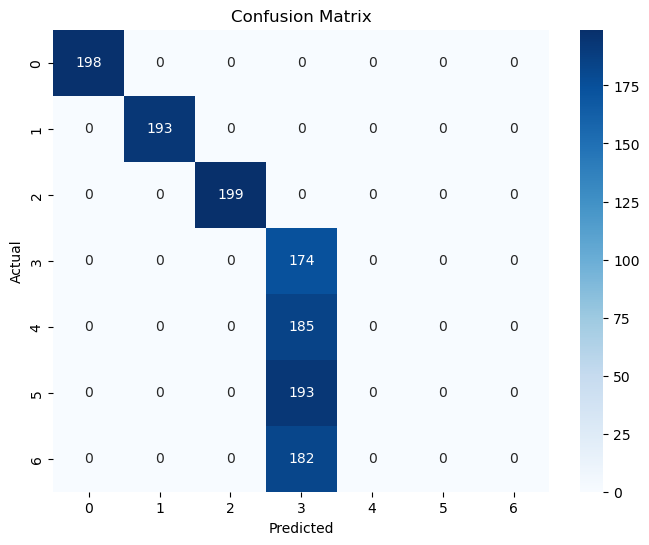

/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.55
Precision: 0.45
Recall: 0.55
F1 Score: 0.47
Cohen’s Kappa: 0.48


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


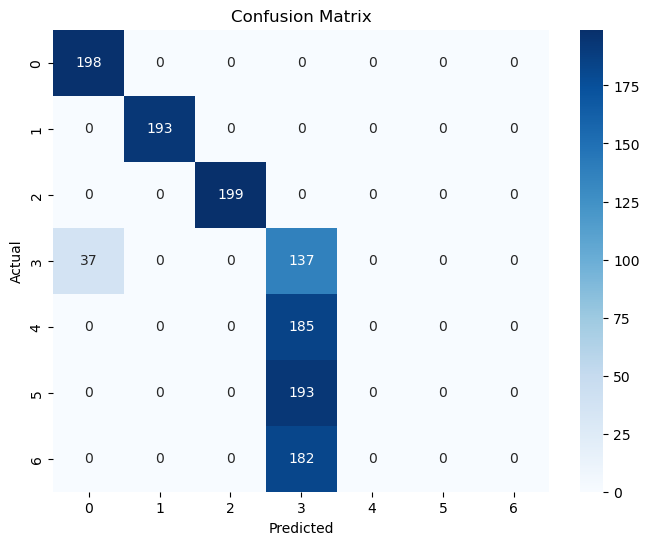


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.45
Precision: 0.33
Recall: 0.45
F1 Score: 0.35
Cohen’s Kappa: 0.35


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


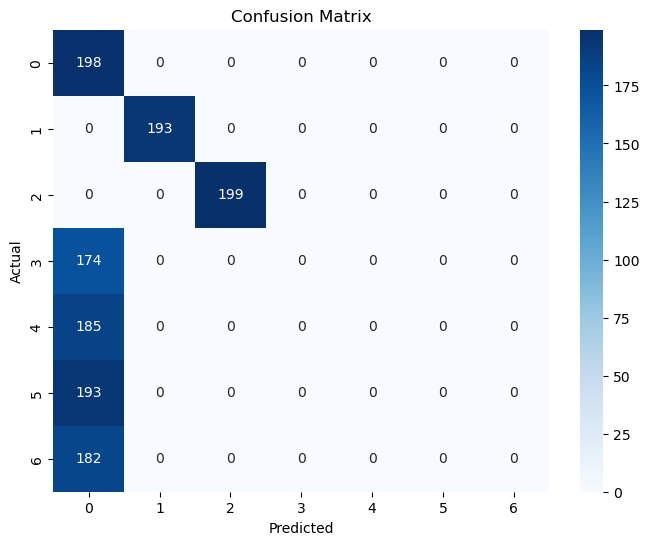


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.45
Precision: 0.33
Recall: 0.45
F1 Score: 0.35
Cohen’s Kappa: 0.35


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


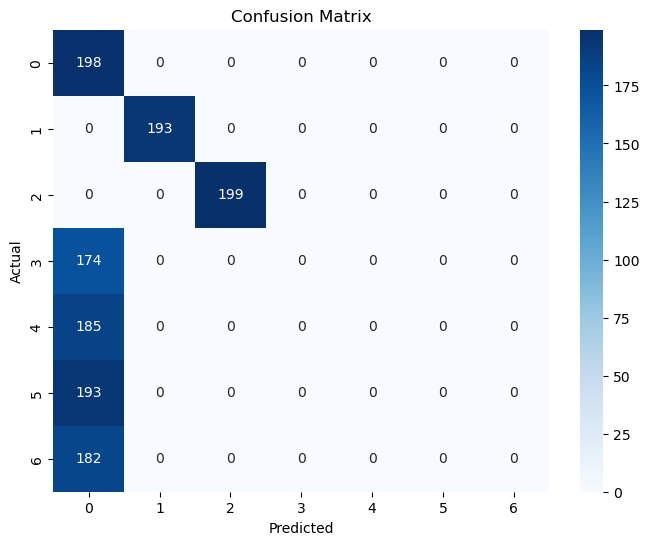


Evaluation Metrics:
Accuracy: 0.45
Precision: 0.33
Recall: 0.45
F1 Score: 0.35
Cohen’s Kappa: 0.35


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


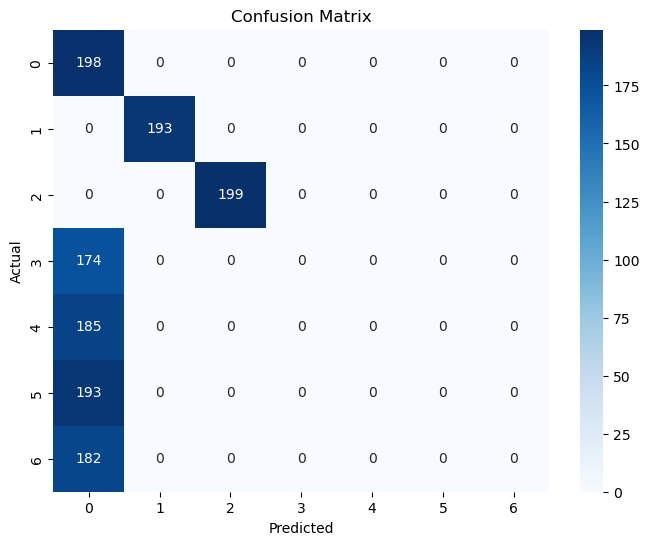

Fold 5/5
Epoch 1/25, Loss: 1.5370, Val Loss: 1.2604
Epoch 2/25, Loss: 1.1304, Val Loss: 0.9974
Epoch 3/25, Loss: 1.1161, Val Loss: 0.9450
Epoch 4/25, Loss: 0.9633, Val Loss: 0.8853
Epoch 5/25, Loss: 0.9125, Val Loss: 0.8582
Epoch 6/25, Loss: 0.9075, Val Loss: 0.8334
Epoch 7/25, Loss: 0.7970, Val Loss: 0.6616
Epoch 8/25, Loss: 0.7062, Val Loss: 0.5935
Epoch 9/25, Loss: 0.6801, Val Loss: 0.5679
Epoch 10/25, Loss: 0.5871, Val Loss: 0.4784
Epoch 11/25, Loss: 0.5314, Val Loss: 0.4946
Epoch 12/25, Loss: 0.4956, Val Loss: 0.4975
Epoch 13/25, Loss: 0.5055, Val Loss: 0.5589
Epoch 14/25, Loss: 0.5011, Val Loss: 0.4210
Epoch 15/25, Loss: 0.4835, Val Loss: 0.4817
Epoch 16/25, Loss: 0.4905, Val Loss: 0.4306
Epoch 17/25, Loss: 0.4508, Val Loss: 0.4030
Epoch 18/25, Loss: 0.4657, Val Loss: 0.4133
Epoch 19/25, Loss: 0.4733, Val Loss: 0.5042
Epoch 20/25, Loss: 0.4830, Val Loss: 0.4385
Epoch 21/25, Loss: 0.4556, Val Loss: 0.4078
Epoch 22/25, Loss: 0.4699, Val Loss: 0.4256
Early stopping triggered.

Evalu


Starting Online Adaptation...


Online Adaptation Cycle 1/3


/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.61
Precision: 0.56
Recall: 0.61
F1 Score: 0.57
Cohen’s Kappa: 0.55


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.43
Precision: 0.34
Recall: 0.43
F1 Score: 0.37
Cohen’s Kappa: 0.33


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Metrics:
Accuracy: 0.41
Precision: 0.32
Recall: 0.41
F1 Score: 0.34
Cohen’s Kappa: 0.31


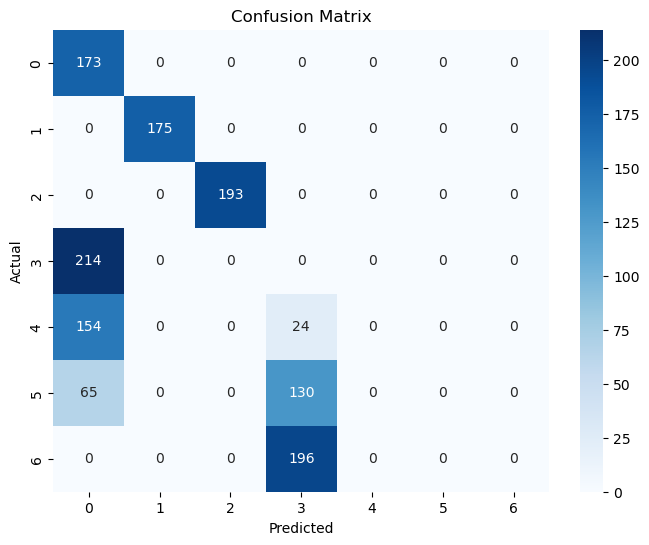


Evaluation Metrics:
Accuracy: 0.41
Precision: 0.32
Recall: 0.41
F1 Score: 0.34
Cohen’s Kappa: 0.31


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


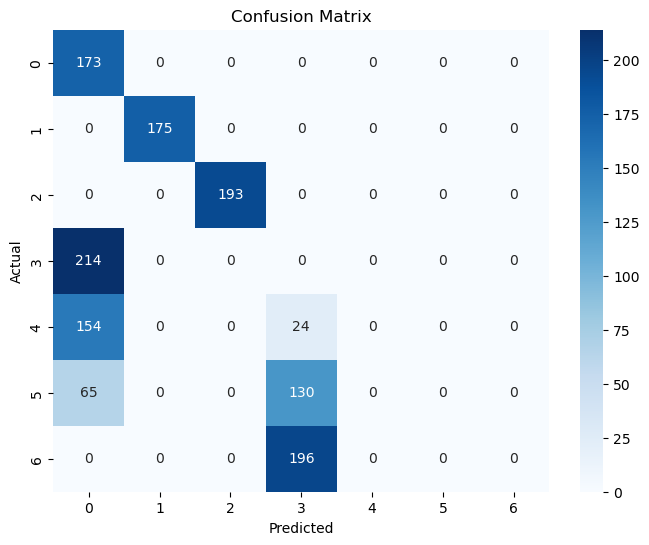


Average Metrics across 5 folds:
Precision: 0.26
Recall: 0.38
F1: 0.28
Accuracy: 0.38
Kappa: 0.27


In [2]:
# Evaluation function with Confusion Matrix and Kappa Score
# Evaluation function with Confusion Matrix and Kappa Score
def evaluate_model(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            eeg = X_batch[:, :input_dim_eeg].unsqueeze(1)
            emg = X_batch[:, input_dim_eeg:].unsqueeze(1)
            outputs = model(eeg, emg)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    print(f"\nEvaluation Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Cohen’s Kappa: {kappa:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return precision, recall, f1, accuracy, kappa
# Online adaptation function with regularization
# Online adaptation function with regularization
def online_adaptation_with_regularization(model, optimizer, buffer_X, buffer_y, criterion, val_loader, num_cycles=3, batch_size=16, lr=0.0001):
    model.train()
    buffer_dataset = EEGEMGDataset(buffer_X, buffer_y)
    buffer_loader = DataLoader(buffer_dataset, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.005)
    
    for cycle in range(num_cycles):
        print(f"\nOnline Adaptation Cycle {cycle + 1}/{num_cycles}")
        for X_batch, y_batch in buffer_loader:
            eeg = X_batch[:, :input_dim_eeg].unsqueeze(1)
            emg = X_batch[:, input_dim_eeg:].unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(eeg, emg)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()

        # Evaluate after each adaptation cycle
        print("\nEvaluation After Online Adaptation Cycle:")
        evaluate_model(model, val_loader)

# Train function with online adaptation
# Train function with online adaptation
def train_model(model, train_loader, val_loader, criterion, epochs=25, patience=5, lr=0.0005, online_adaptation=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            eeg = X_batch[:, :input_dim_eeg].unsqueeze(1)
            emg = X_batch[:, input_dim_eeg:].unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(eeg, emg)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                eeg = X_batch[:, :input_dim_eeg].unsqueeze(1)
                emg = X_batch[:, input_dim_eeg:].unsqueeze(1)
                outputs = model(eeg, emg)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(best_model_state)
                break

    # Print evaluation before online adaptation
    print("\nEvaluation Before Online Adaptation:")
    evaluate_model(model, val_loader)

    # Online Adaptation Phase
    if online_adaptation:
        print("\nStarting Online Adaptation...\n")
        buffer_size = int(len(train_loader.dataset) * 0.3)  # 30% data for online adaptation
        buffer_X, buffer_y = train_loader.dataset.X[:buffer_size], train_loader.dataset.y[:buffer_size]
        online_adaptation_with_regularization(model, optimizer, buffer_X, buffer_y, criterion, val_loader)

# k-Fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_results = []

for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{k}")
    X_train, X_val = data[train_index], data[val_index]
    y_train, y_val = labels[train_index], labels[val_index]
    train_dataset = EEGEMGDataset(X_train, y_train)
    val_dataset = EEGEMGDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    input_dim_eeg = eeg_data.shape[1]
    input_dim_emg = emg_data.shape[1]
    num_classes = len(np.unique(labels))

    # Select model: CNN-GRU, CNN-RNN, or TCN
    #model = EEGEMGCNNGRU(input_dim_eeg=input_dim_eeg, input_dim_emg=input_dim_emg, num_classes=num_classes)
    model = EEGEMGCNNRNN(input_dim_eeg=input_dim_eeg, input_dim_emg=input_dim_emg, num_classes=num_classes)
    # model = EEGEMGTCN(input_dim_eeg=input_dim_eeg, input_dim_emg=input_dim_emg, num_classes=num_classes)

    criterion = nn.CrossEntropyLoss()
    train_model(model, train_loader, val_loader, criterion, online_adaptation=True)
    precision, recall, f1, accuracy, kappa = evaluate_model(model, val_loader)
    fold_results.append({'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy, 'kappa': kappa})

# Average metrics
average_metrics = {metric: np.mean([result[metric] for result in fold_results]) for metric in fold_results[0]}
print(f"\nAverage Metrics across {k} folds:")
for metric, value in average_metrics.items():
    print(f"{metric.capitalize()}: {value:.2f}")

Fold 1/5
Epoch 1/25, Loss: 1.9470, Val Loss: 1.9451
Epoch 2/25, Loss: 1.9464, Val Loss: 1.9453
Epoch 3/25, Loss: 1.9464, Val Loss: 1.9456
Epoch 4/25, Loss: 1.9465, Val Loss: 1.9456
Epoch 5/25, Loss: 1.9461, Val Loss: 1.9458
Epoch 6/25, Loss: 1.9460, Val Loss: 1.9459
Early stopping triggered.

Evaluation Before Online Adaptation:

Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


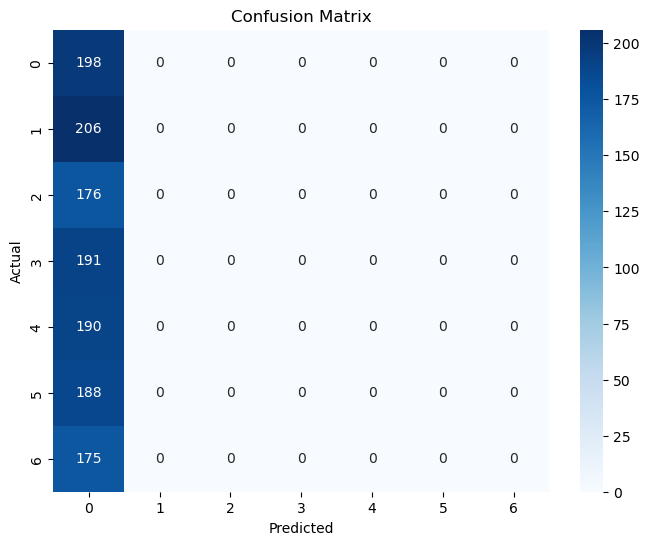

/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


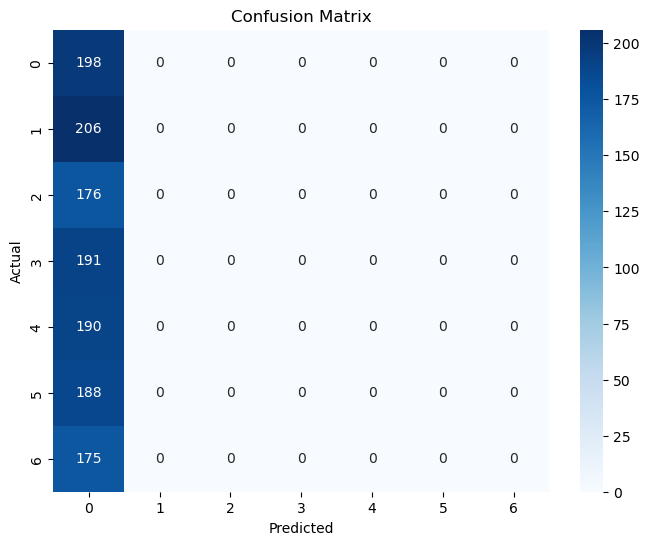


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.16
Precision: 0.02
Recall: 0.16
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


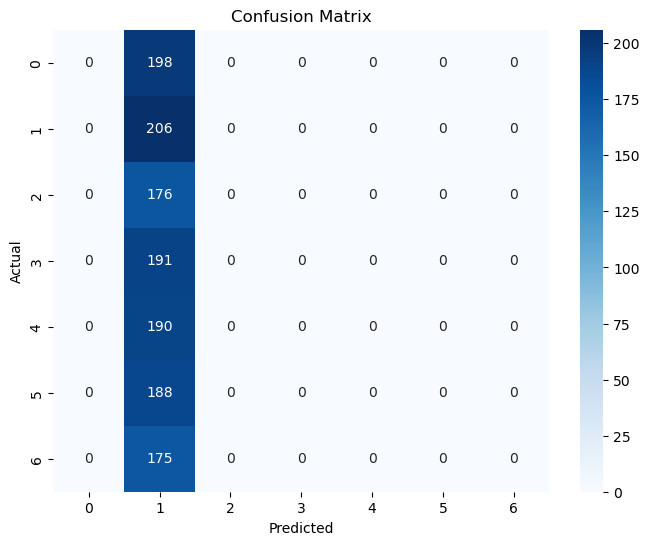


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


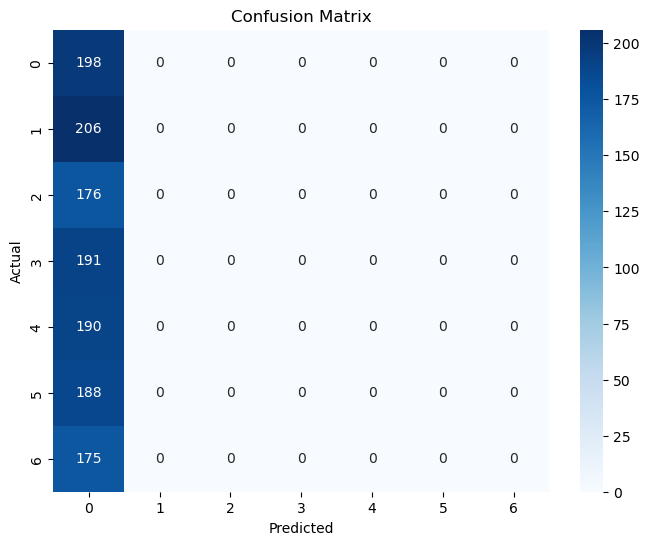


Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


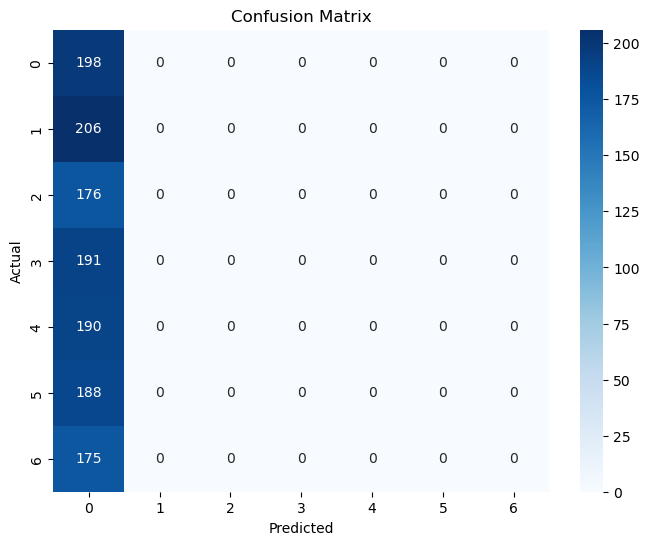

Fold 2/5
Epoch 1/25, Loss: 1.9470, Val Loss: 1.9462
Epoch 2/25, Loss: 1.9463, Val Loss: 1.9464
Epoch 3/25, Loss: 1.9461, Val Loss: 1.9466
Epoch 4/25, Loss: 1.9461, Val Loss: 1.9466
Epoch 5/25, Loss: 1.9458, Val Loss: 1.9467
Epoch 6/25, Loss: 1.9458, Val Loss: 1.9467
Early stopping triggered.

Evaluation Before Online Adaptation:

Evaluation Metrics:
Accuracy: 0.14
Precision: 0.02
Recall: 0.14
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


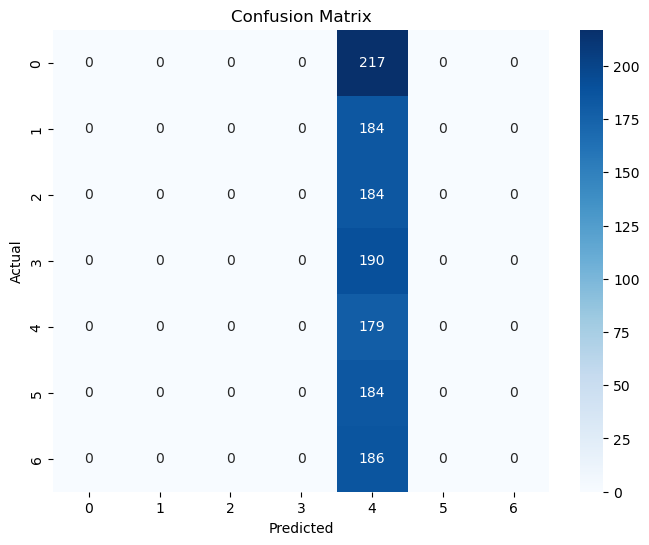

/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.14
Precision: 0.02
Recall: 0.14
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


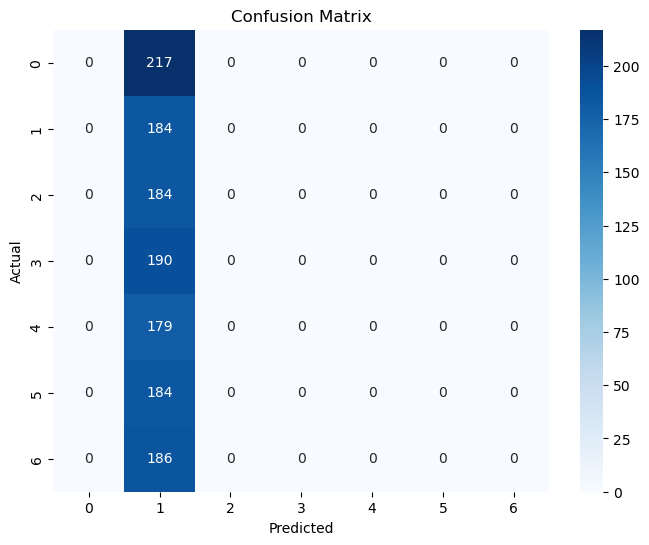


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.14
Precision: 0.02
Recall: 0.14
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


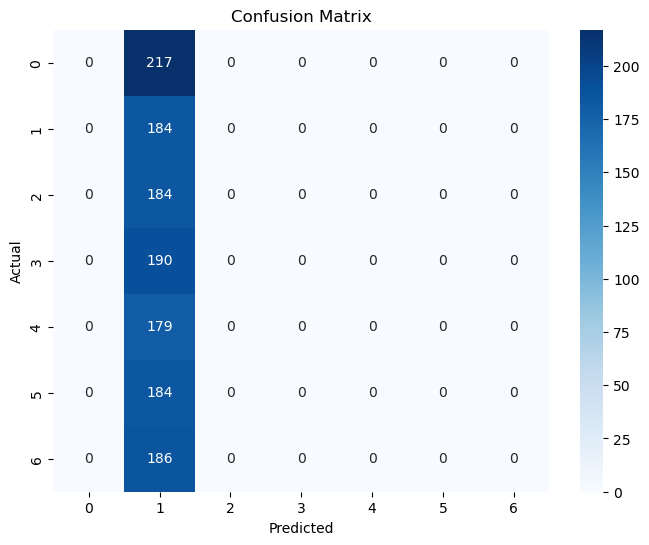


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.16
Precision: 0.03
Recall: 0.16
F1 Score: 0.05
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


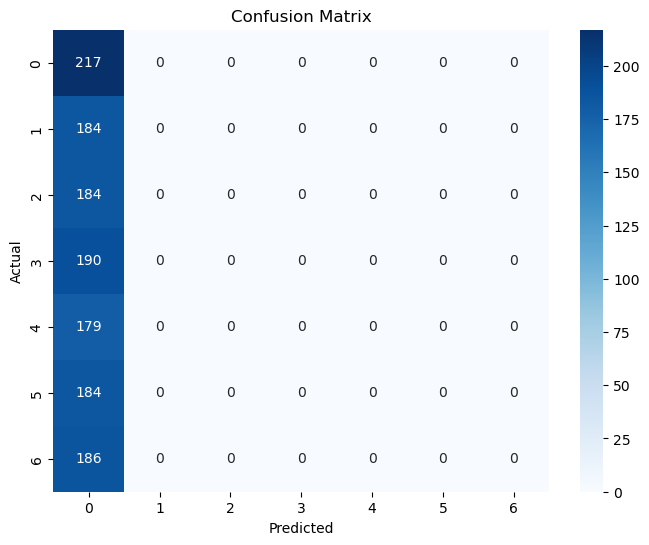


Evaluation Metrics:
Accuracy: 0.16
Precision: 0.03
Recall: 0.16
F1 Score: 0.05
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


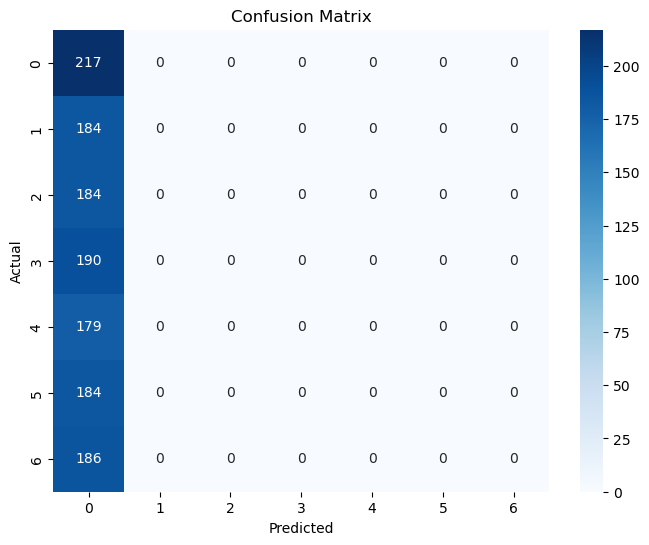

Fold 3/5
Epoch 1/25, Loss: 1.9469, Val Loss: 1.9465
Epoch 2/25, Loss: 1.9463, Val Loss: 1.9465
Epoch 3/25, Loss: 1.9462, Val Loss: 1.9468
Epoch 4/25, Loss: 1.9459, Val Loss: 1.9471
Epoch 5/25, Loss: 1.9461, Val Loss: 1.9470
Epoch 6/25, Loss: 1.9459, Val Loss: 1.9471
Epoch 7/25, Loss: 1.9459, Val Loss: 1.9470
Early stopping triggered.

Evaluation Before Online Adaptation:

Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


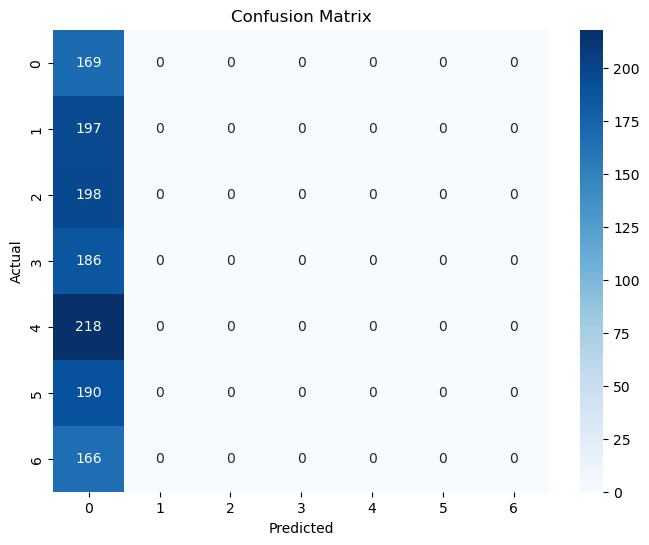

/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


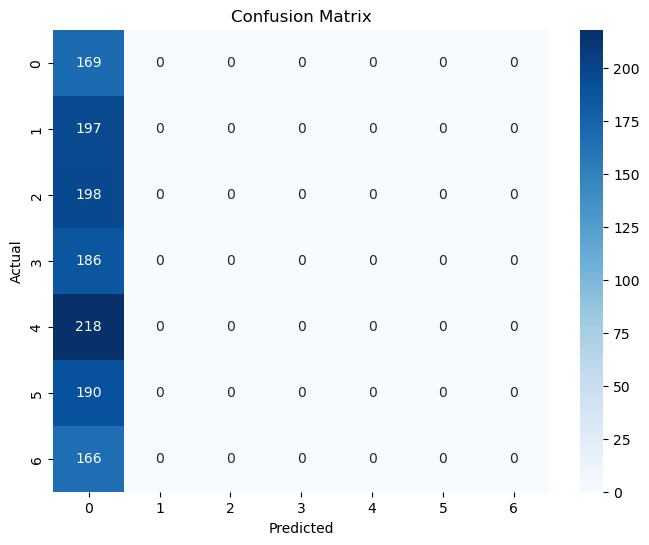


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


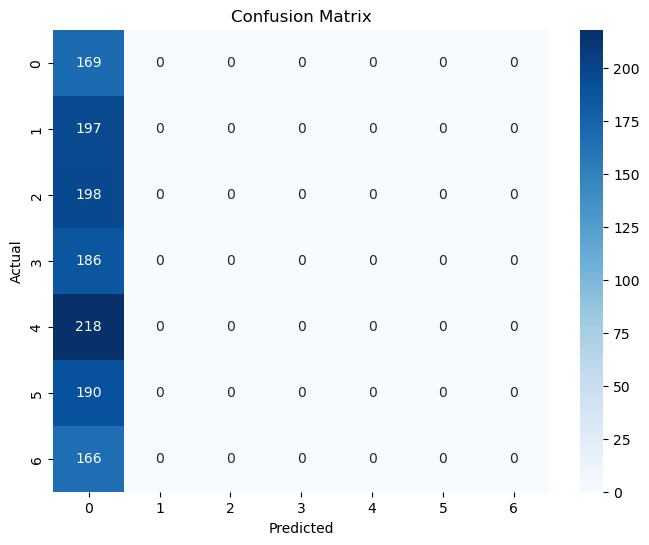


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


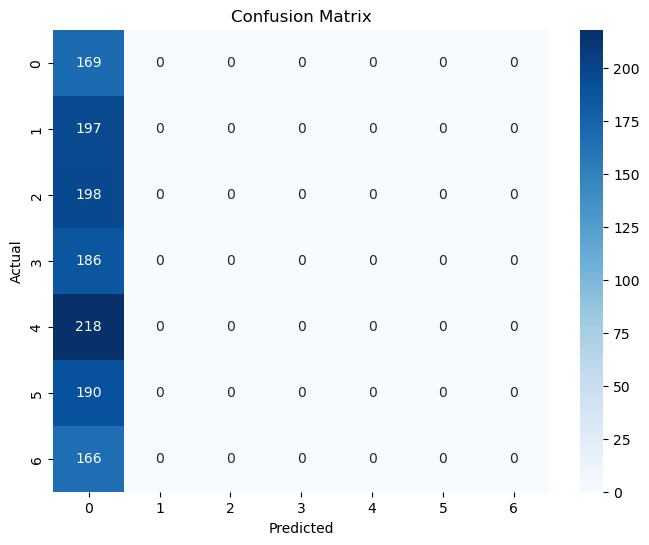


Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


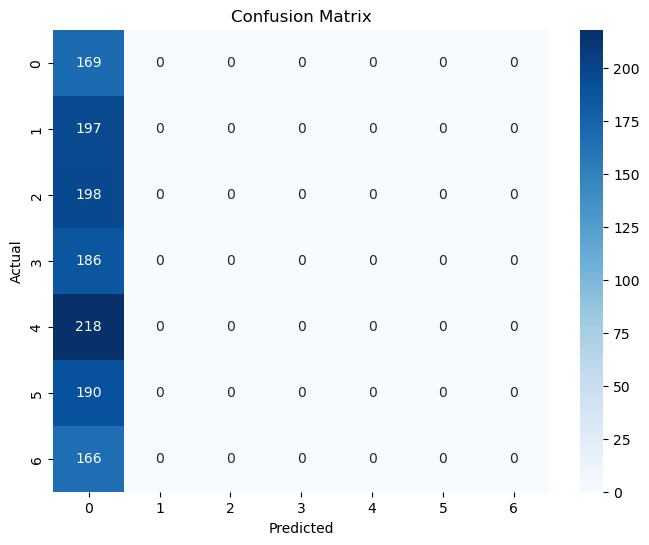

Fold 4/5
Epoch 1/25, Loss: 1.9468, Val Loss: 1.9462
Epoch 2/25, Loss: 1.9461, Val Loss: 1.9463
Epoch 3/25, Loss: 1.9464, Val Loss: 1.9462
Epoch 4/25, Loss: 1.9461, Val Loss: 1.9463
Epoch 5/25, Loss: 1.9462, Val Loss: 1.9463
Epoch 6/25, Loss: 1.9459, Val Loss: 1.9464
Epoch 7/25, Loss: 1.9460, Val Loss: 1.9464
Epoch 8/25, Loss: 1.9459, Val Loss: 1.9465
Early stopping triggered.

Evaluation Before Online Adaptation:

Evaluation Metrics:
Accuracy: 0.14
Precision: 0.02
Recall: 0.14
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


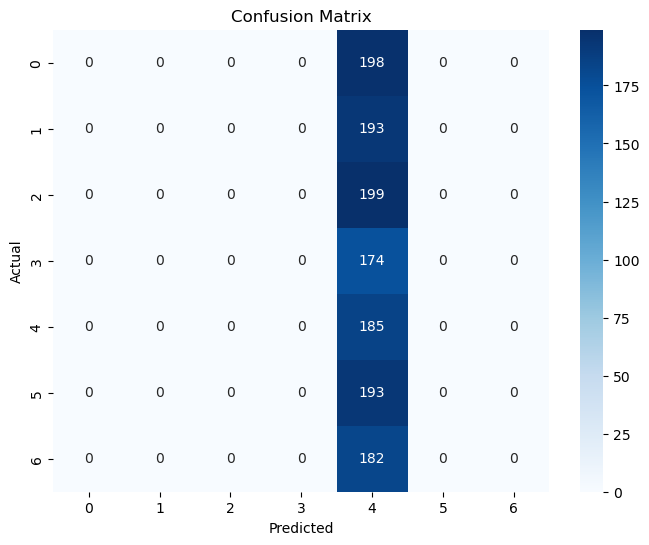

/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


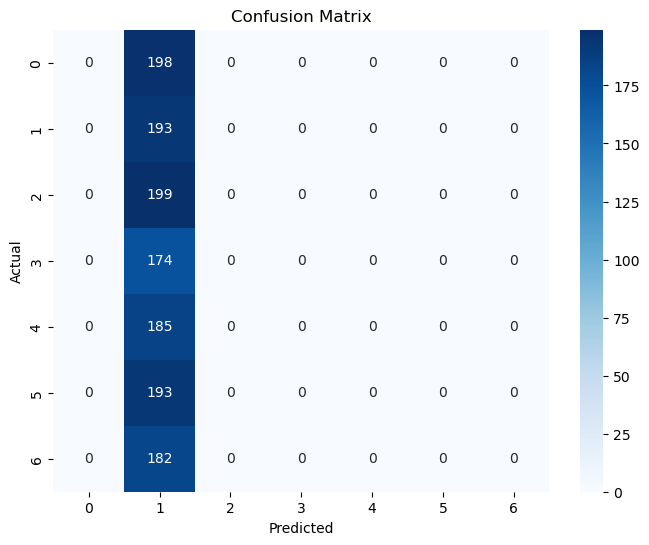


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


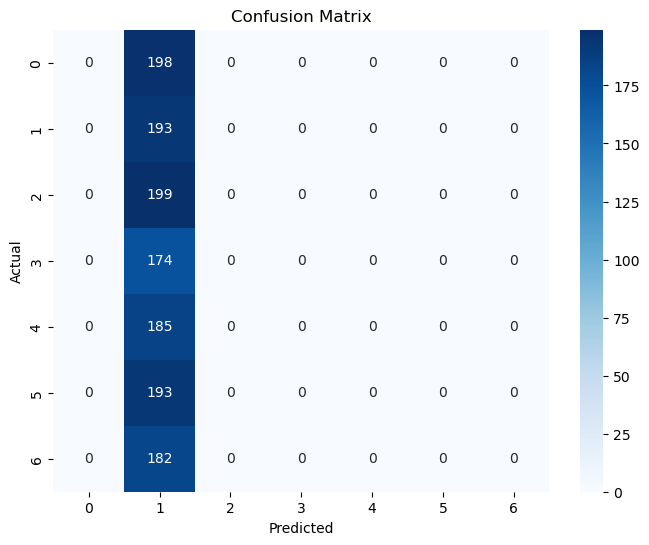


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Metrics:
Accuracy: 0.15
Precision: 0.02
Recall: 0.15
F1 Score: 0.04
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 5/5
Epoch 1/25, Loss: 1.9462, Val Loss: 1.9480
Epoch 2/25, Loss: 1.9460, Val Loss: 1.9485
Epoch 3/25, Loss: 1.9459, Val Loss: 1.9483
Epoch 4/25, Loss: 1.9458, Val Loss: 1.9487
Epoch 5/25, Loss: 1.9455, Val Loss: 1.9486
Epoch 6/25, Loss: 1.9457, Val Loss: 1.9485
Early stopping triggered.

Evaluation Before Online Adaptation:

Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


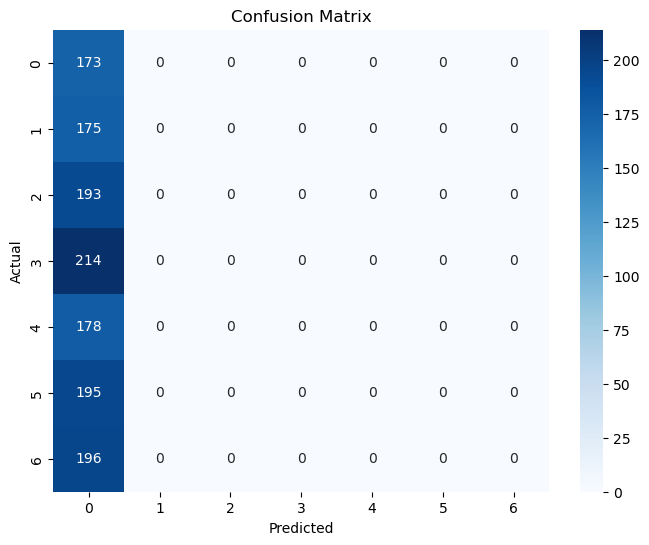


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


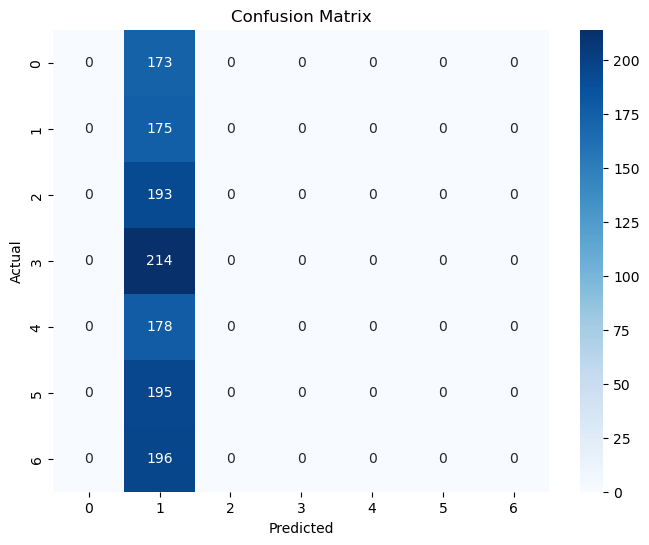


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


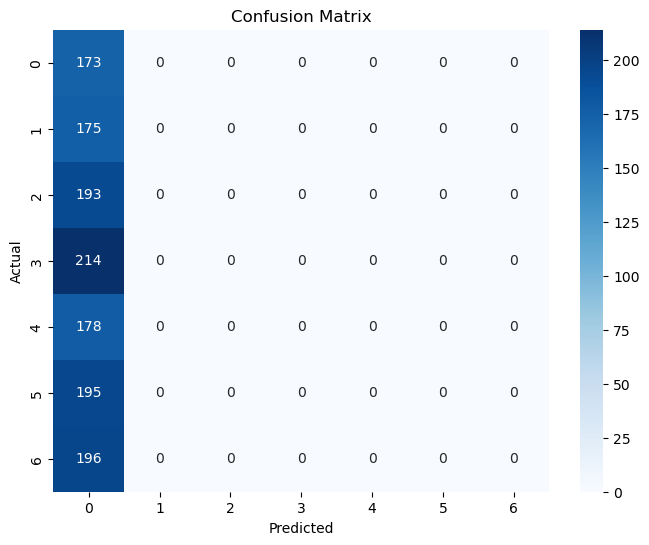


Evaluation Metrics:
Accuracy: 0.13
Precision: 0.02
Recall: 0.13
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


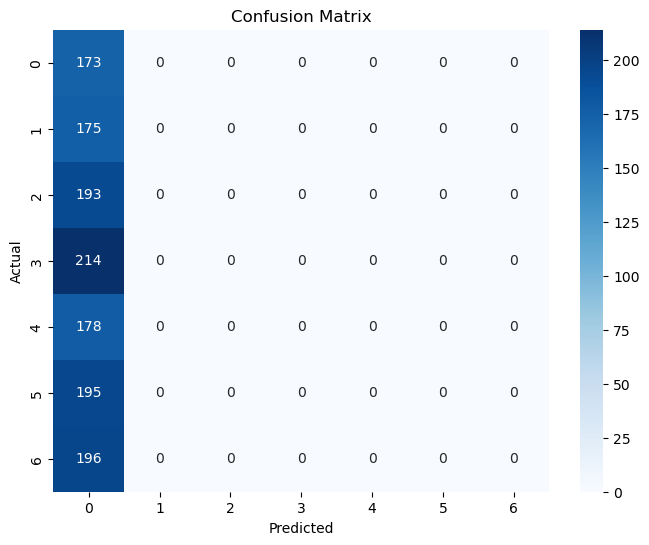


Average Metrics across 5 folds:
Precision: 0.14
Recall: 0.26
F1: 0.16
Accuracy: 0.26
Kappa: 0.14


In [3]:

for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{k}")
    X_train, X_val = data[train_index], data[val_index]
    y_train, y_val = labels[train_index], labels[val_index]
    train_dataset = EEGEMGDataset(X_train, y_train)
    val_dataset = EEGEMGDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    input_dim_eeg = eeg_data.shape[1]
    input_dim_emg = emg_data.shape[1]
    num_classes = len(np.unique(labels))

    # Select model: CNN-GRU, CNN-RNN, or TCN
    #model = EEGEMGCNNGRU(input_dim_eeg=input_dim_eeg, input_dim_emg=input_dim_emg, num_classes=num_classes)
    #model = EEGEMGCNNRNN(input_dim_eeg=input_dim_eeg, input_dim_emg=input_dim_emg, num_classes=num_classes)
    model = EEGEMGTCN(input_dim_eeg=input_dim_eeg, input_dim_emg=input_dim_emg, num_classes=num_classes)

    criterion = nn.CrossEntropyLoss()
    train_model(model, train_loader, val_loader, criterion, online_adaptation=True)
    precision, recall, f1, accuracy, kappa = evaluate_model(model, val_loader)
    fold_results.append({'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy, 'kappa': kappa})

# Average metrics
average_metrics = {metric: np.mean([result[metric] for result in fold_results]) for metric in fold_results[0]}
print(f"\nAverage Metrics across {k} folds:")
for metric, value in average_metrics.items():
    print(f"{metric.capitalize()}: {value:.2f}")

Fold 1/5
Epoch 1/25, Loss: 1.6683, Val Loss: 1.2343
Epoch 2/25, Loss: 1.1101, Val Loss: 0.9789
Epoch 3/25, Loss: 0.9613, Val Loss: 0.8922
Epoch 4/25, Loss: 0.9099, Val Loss: 0.8806
Epoch 5/25, Loss: 0.8359, Val Loss: 0.8027
Epoch 6/25, Loss: 0.6620, Val Loss: 0.6461
Epoch 7/25, Loss: 0.6494, Val Loss: 0.5495
Epoch 8/25, Loss: 0.5580, Val Loss: 0.4869
Epoch 9/25, Loss: 0.4757, Val Loss: 0.4053
Epoch 10/25, Loss: 0.4561, Val Loss: 0.4426
Epoch 11/25, Loss: 0.4773, Val Loss: 0.4384
Epoch 12/25, Loss: 0.4321, Val Loss: 0.4057
Epoch 13/25, Loss: 0.4229, Val Loss: 0.4219
Epoch 14/25, Loss: 0.4316, Val Loss: 0.4013
Epoch 15/25, Loss: 0.4190, Val Loss: 0.4033
Epoch 16/25, Loss: 0.4246, Val Loss: 0.4035
Epoch 17/25, Loss: 0.4130, Val Loss: 0.4039
Epoch 18/25, Loss: 0.4193, Val Loss: 0.4039
Epoch 19/25, Loss: 0.4057, Val Loss: 0.3868
Epoch 20/25, Loss: 0.4199, Val Loss: 0.4350
Epoch 21/25, Loss: 0.4147, Val Loss: 0.4190
Epoch 22/25, Loss: 0.4094, Val Loss: 0.4765
Epoch 23/25, Loss: 0.4637, Val L

/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


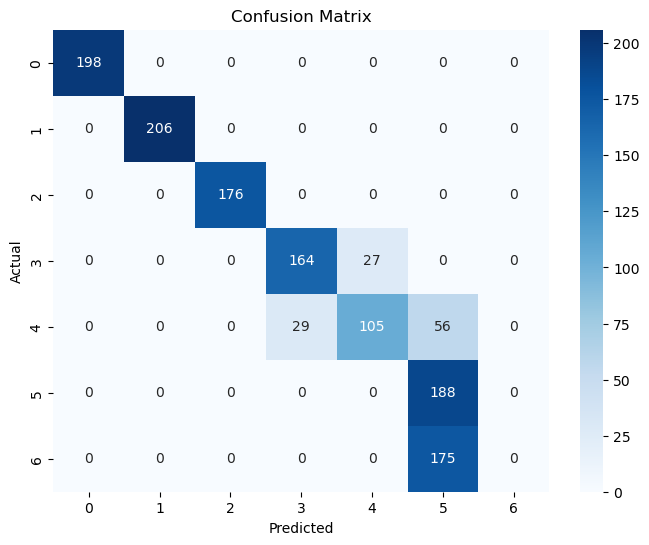

/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.61
Precision: 0.57
Recall: 0.61
F1 Score: 0.56
Cohen’s Kappa: 0.54


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


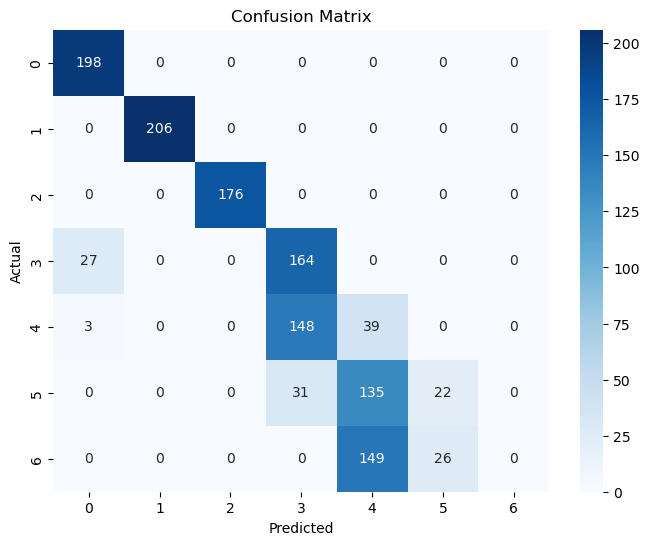


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Metrics:
Accuracy: 0.44
Precision: 0.36
Recall: 0.44
F1 Score: 0.39
Cohen’s Kappa: 0.35


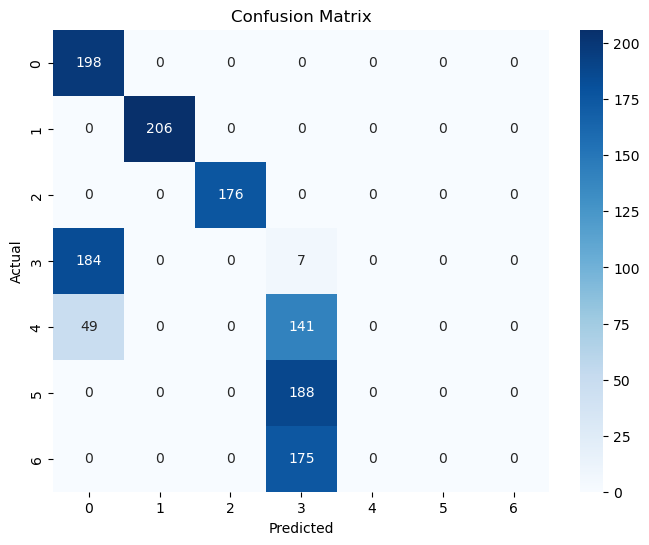


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.44
Precision: 0.32
Recall: 0.44
F1 Score: 0.34
Cohen’s Kappa: 0.34


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


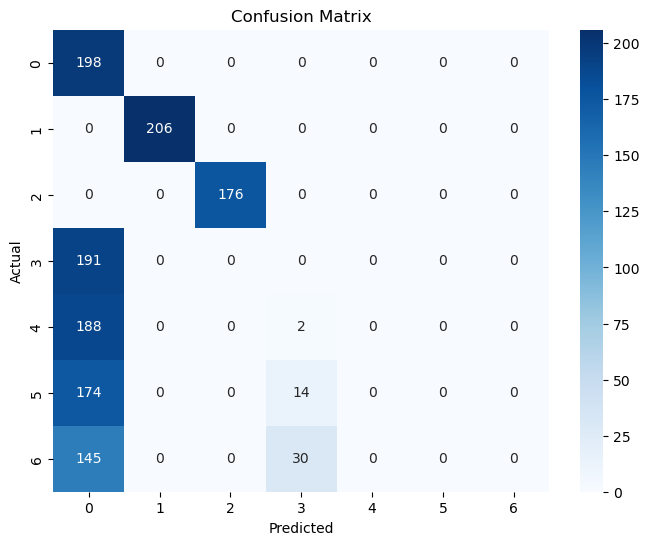


Evaluation Metrics:
Accuracy: 0.44
Precision: 0.32
Recall: 0.44
F1 Score: 0.34
Cohen’s Kappa: 0.34


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


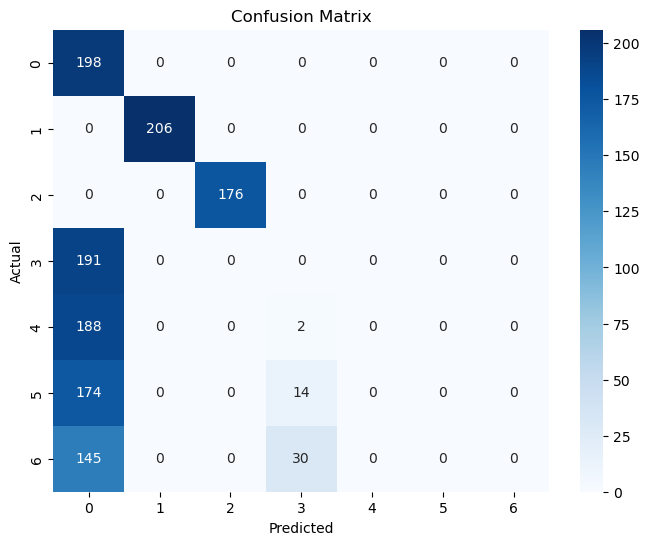

Fold 2/5
Epoch 1/25, Loss: 1.9462, Val Loss: 1.9481
Epoch 2/25, Loss: 1.9464, Val Loss: 1.9478
Epoch 3/25, Loss: 1.9461, Val Loss: 1.9476
Epoch 4/25, Loss: 1.9460, Val Loss: 1.9476
Epoch 5/25, Loss: 1.9460, Val Loss: 1.9478
Epoch 6/25, Loss: 1.9457, Val Loss: 1.9477
Epoch 7/25, Loss: 1.9456, Val Loss: 1.9477
Epoch 8/25, Loss: 1.9458, Val Loss: 1.9477
Epoch 9/25, Loss: 1.9457, Val Loss: 1.9477
Early stopping triggered.

Evaluation Before Online Adaptation:

Evaluation Metrics:
Accuracy: 0.14
Precision: 0.02
Recall: 0.14
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


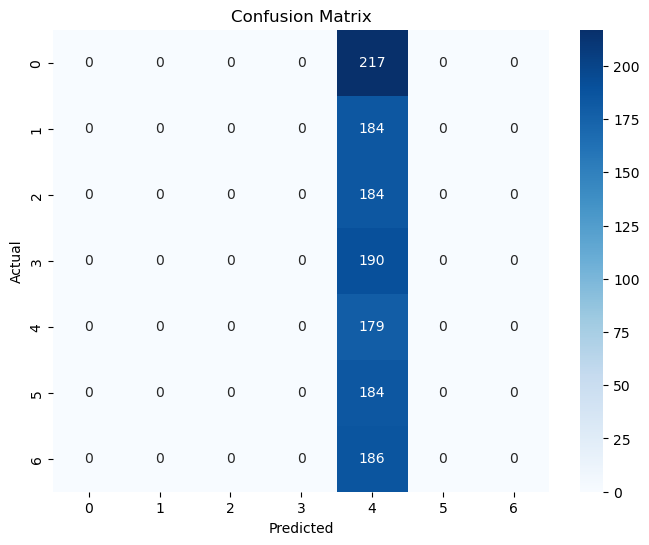

/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.14
Precision: 0.02
Recall: 0.14
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


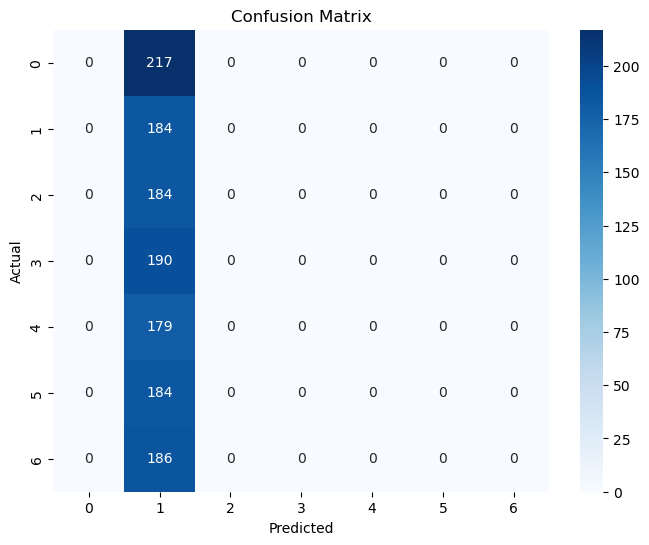


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.16
Precision: 0.03
Recall: 0.16
F1 Score: 0.05
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


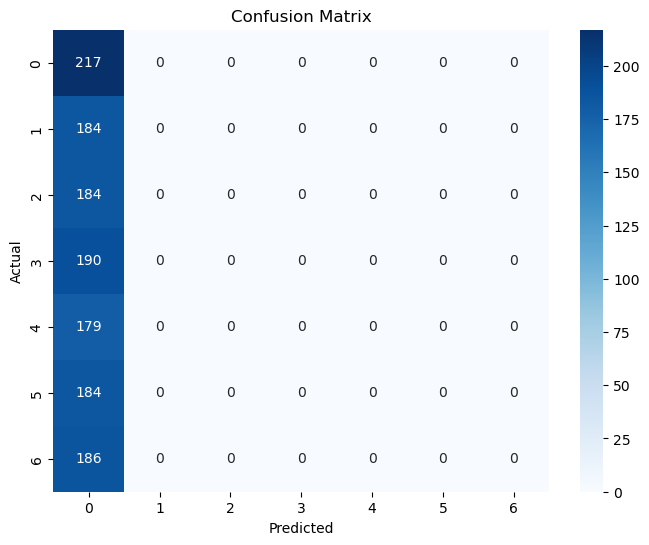


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.14
Precision: 0.02
Recall: 0.14
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


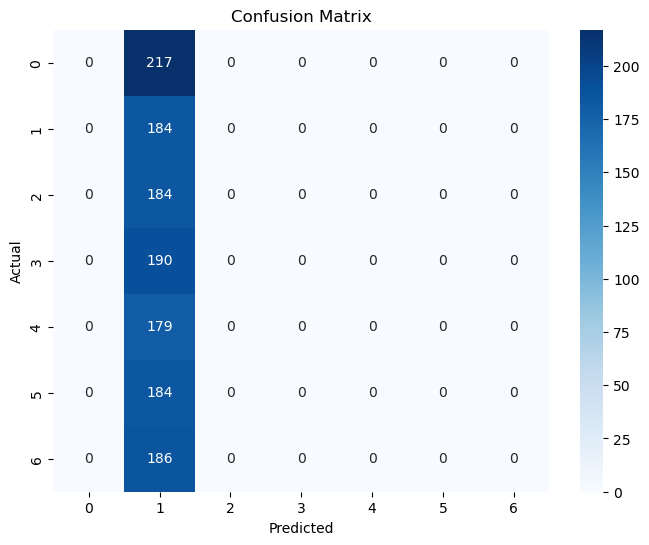


Evaluation Metrics:
Accuracy: 0.14
Precision: 0.02
Recall: 0.14
F1 Score: 0.03
Cohen’s Kappa: 0.00


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


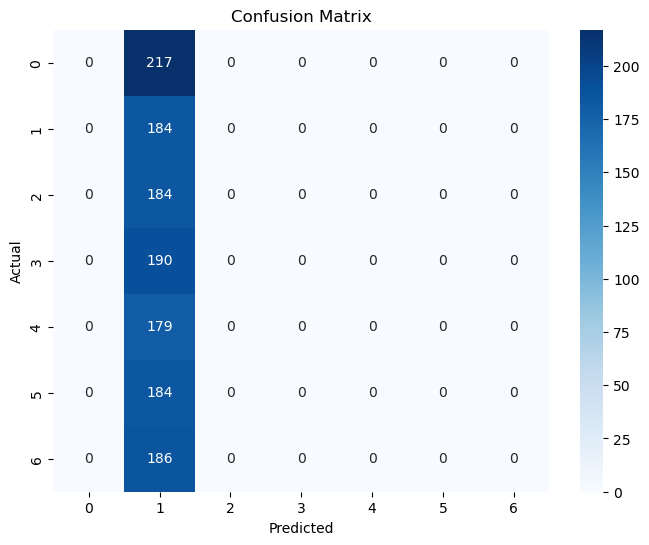

Fold 3/5
Epoch 1/25, Loss: 1.8826, Val Loss: 1.3072
Epoch 2/25, Loss: 1.2703, Val Loss: 1.1992
Epoch 3/25, Loss: 1.0567, Val Loss: 0.9677
Epoch 4/25, Loss: 0.9224, Val Loss: 0.8960
Epoch 5/25, Loss: 0.7553, Val Loss: 0.6443
Epoch 6/25, Loss: 0.6578, Val Loss: 0.5678
Epoch 7/25, Loss: 0.5482, Val Loss: 0.5795
Epoch 8/25, Loss: 0.4927, Val Loss: 0.4542
Epoch 9/25, Loss: 0.4746, Val Loss: 0.4397
Epoch 10/25, Loss: 0.4653, Val Loss: 0.4082
Epoch 11/25, Loss: 0.4748, Val Loss: 0.4240
Epoch 12/25, Loss: 0.4434, Val Loss: 0.4171
Epoch 13/25, Loss: 0.4426, Val Loss: 0.4462
Epoch 14/25, Loss: 0.4495, Val Loss: 0.4945
Epoch 15/25, Loss: 0.4497, Val Loss: 0.4095
Early stopping triggered.

Evaluation Before Online Adaptation:

Evaluation Metrics:
Accuracy: 0.81
Precision: 0.83
Recall: 0.81
F1 Score: 0.80
Cohen’s Kappa: 0.78


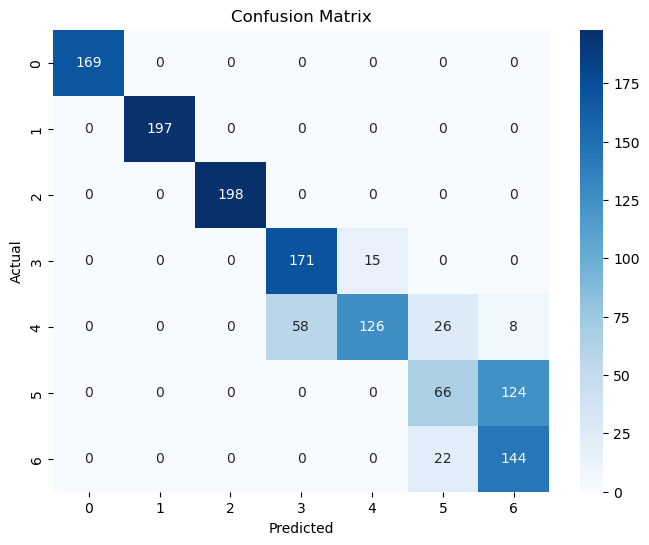


Starting Online Adaptation...


Online Adaptation Cycle 1/3


/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.68
Precision: 0.61
Recall: 0.68
F1 Score: 0.63
Cohen’s Kappa: 0.62


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.44
Precision: 0.36
Recall: 0.44
F1 Score: 0.38
Cohen’s Kappa: 0.35


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Metrics:
Accuracy: 0.43
Precision: 0.34
Recall: 0.43
F1 Score: 0.36
Cohen’s Kappa: 0.33



Evaluation Metrics:
Accuracy: 0.43
Precision: 0.34
Recall: 0.43
F1 Score: 0.36
Cohen’s Kappa: 0.33


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


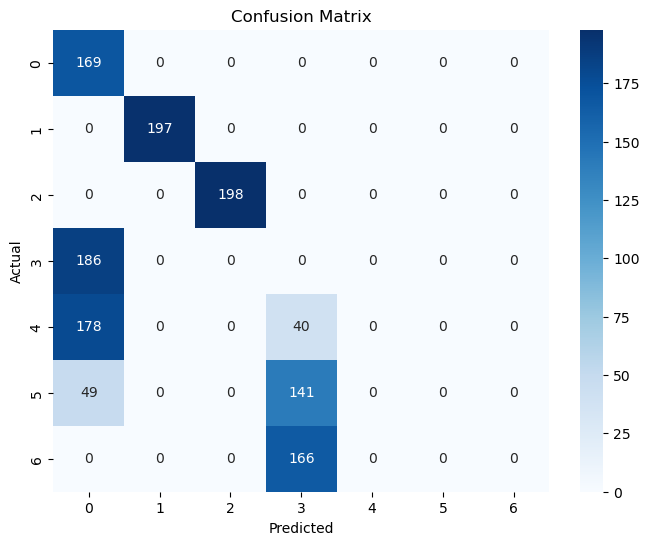

Fold 4/5
Epoch 1/25, Loss: 1.6939, Val Loss: 1.2492
Epoch 2/25, Loss: 1.1084, Val Loss: 0.9531
Epoch 3/25, Loss: 0.9589, Val Loss: 0.8720
Epoch 4/25, Loss: 0.9225, Val Loss: 0.8724
Epoch 5/25, Loss: 0.9070, Val Loss: 0.8533
Epoch 6/25, Loss: 0.8880, Val Loss: 0.8499
Epoch 7/25, Loss: 0.9113, Val Loss: 0.8607
Epoch 8/25, Loss: 0.8774, Val Loss: 0.8465
Epoch 9/25, Loss: 0.8716, Val Loss: 0.9227
Epoch 10/25, Loss: 0.8787, Val Loss: 0.8530
Epoch 11/25, Loss: 0.8946, Val Loss: 0.8582
Epoch 12/25, Loss: 0.8848, Val Loss: 0.8531
Epoch 13/25, Loss: 0.8764, Val Loss: 0.8390
Epoch 14/25, Loss: 0.8718, Val Loss: 0.8378
Epoch 15/25, Loss: 0.8815, Val Loss: 0.8267
Epoch 16/25, Loss: 0.8688, Val Loss: 0.8472
Epoch 17/25, Loss: 0.8737, Val Loss: 0.8201
Epoch 18/25, Loss: 0.8784, Val Loss: 0.8323
Epoch 19/25, Loss: 0.8638, Val Loss: 0.8872
Epoch 20/25, Loss: 0.8822, Val Loss: 0.8688
Epoch 21/25, Loss: 0.8598, Val Loss: 0.8452
Epoch 22/25, Loss: 0.8676, Val Loss: 0.8224
Early stopping triggered.

Evalu

/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Starting Online Adaptation...


Online Adaptation Cycle 1/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.44
Precision: 0.32
Recall: 0.44
F1 Score: 0.33
Cohen’s Kappa: 0.35


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


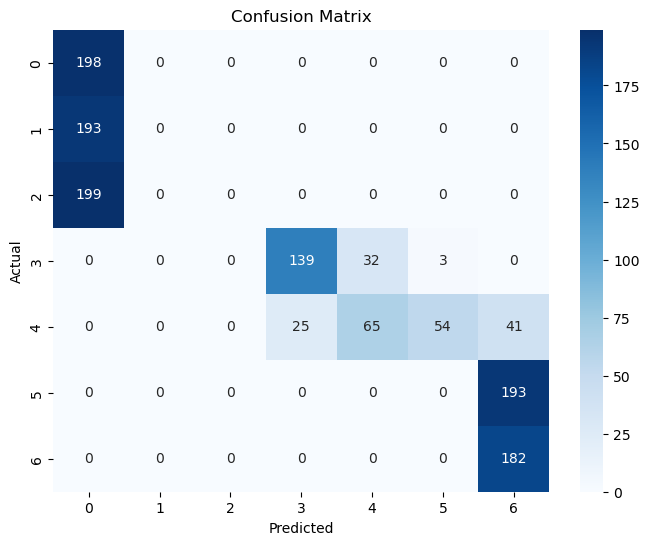


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.54
Precision: 0.43
Recall: 0.54
F1 Score: 0.46
Cohen’s Kappa: 0.46


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


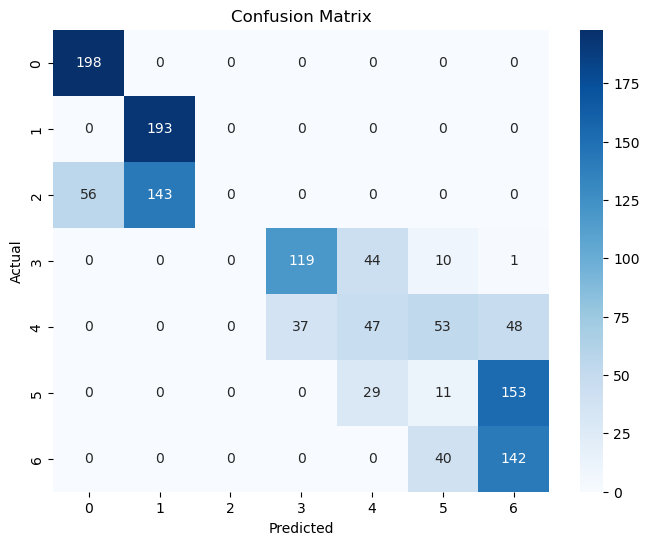


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.54
Precision: 0.38
Recall: 0.54
F1 Score: 0.44
Cohen’s Kappa: 0.47


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


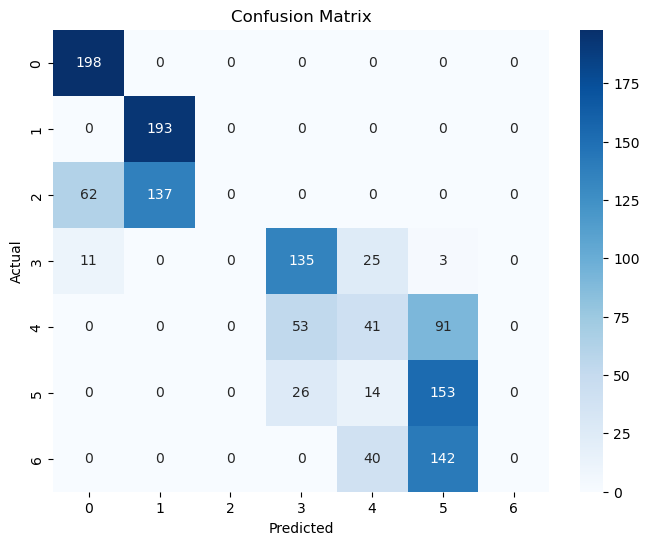


Evaluation Metrics:
Accuracy: 0.54
Precision: 0.38
Recall: 0.54
F1 Score: 0.44
Cohen’s Kappa: 0.47


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


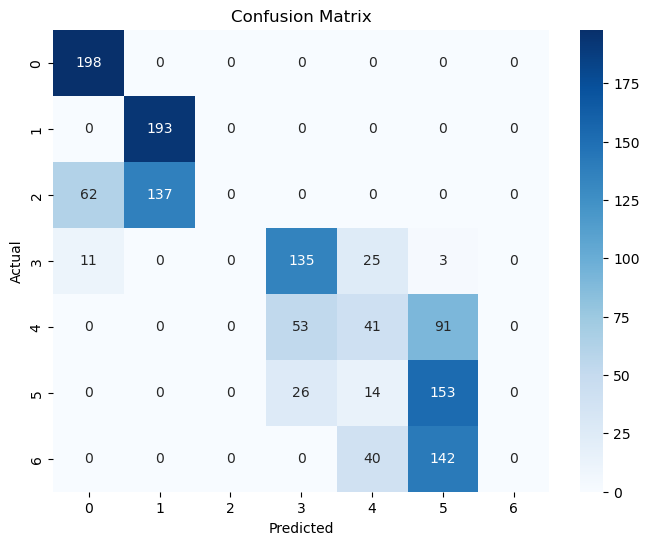

Fold 5/5
Epoch 1/25, Loss: 1.7080, Val Loss: 1.2573
Epoch 2/25, Loss: 1.1539, Val Loss: 0.9826
Epoch 3/25, Loss: 0.9933, Val Loss: 0.8973
Epoch 4/25, Loss: 0.9133, Val Loss: 0.7817
Epoch 5/25, Loss: 0.7531, Val Loss: 0.6458
Epoch 6/25, Loss: 0.6394, Val Loss: 0.5676
Epoch 7/25, Loss: 0.5882, Val Loss: 0.5976
Epoch 8/25, Loss: 0.5288, Val Loss: 0.4547
Epoch 9/25, Loss: 0.4907, Val Loss: 0.4542
Epoch 10/25, Loss: 0.4644, Val Loss: 0.4233
Epoch 11/25, Loss: 0.4644, Val Loss: 0.4146
Epoch 12/25, Loss: 0.4518, Val Loss: 0.4196
Epoch 13/25, Loss: 0.4379, Val Loss: 0.4168
Epoch 14/25, Loss: 0.4398, Val Loss: 0.4559
Epoch 15/25, Loss: 0.4297, Val Loss: 0.4220
Epoch 16/25, Loss: 0.4352, Val Loss: 0.3998
Epoch 17/25, Loss: 0.4155, Val Loss: 0.4005
Epoch 18/25, Loss: 0.4235, Val Loss: 0.3914
Epoch 19/25, Loss: 0.4216, Val Loss: 0.3925
Epoch 20/25, Loss: 0.4200, Val Loss: 0.3910
Epoch 21/25, Loss: 0.4213, Val Loss: 0.4195
Epoch 22/25, Loss: 0.4456, Val Loss: 0.4381
Epoch 23/25, Loss: 0.4288, Val L

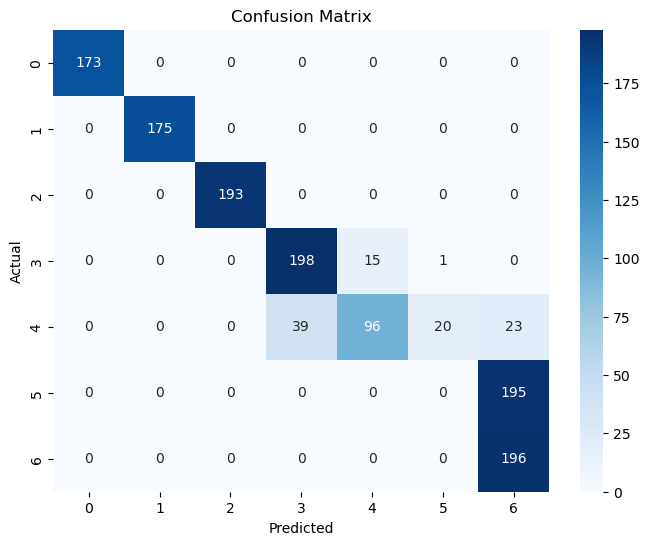


Starting Online Adaptation...


Online Adaptation Cycle 1/3


/tmp/ipykernel_641027/2673362254.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_641027/2673362254.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)



Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.46
Precision: 0.41
Recall: 0.46
F1 Score: 0.41
Cohen’s Kappa: 0.37


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


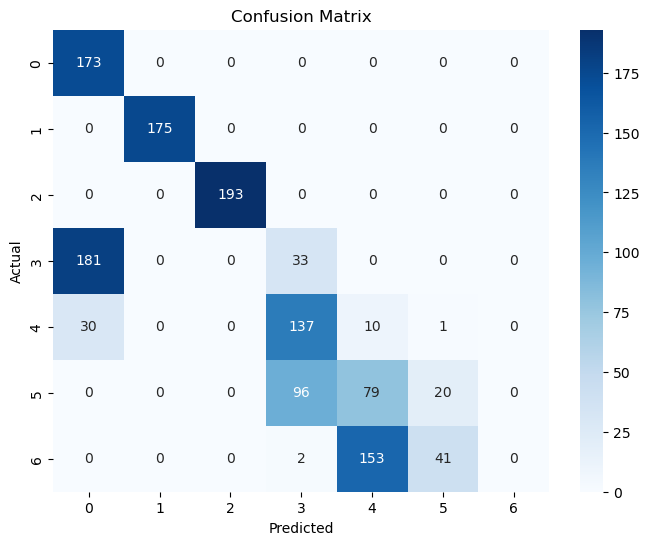


Online Adaptation Cycle 2/3

Evaluation After Online Adaptation Cycle:

Evaluation Metrics:
Accuracy: 0.41
Precision: 0.32
Recall: 0.41
F1 Score: 0.34
Cohen’s Kappa: 0.31


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


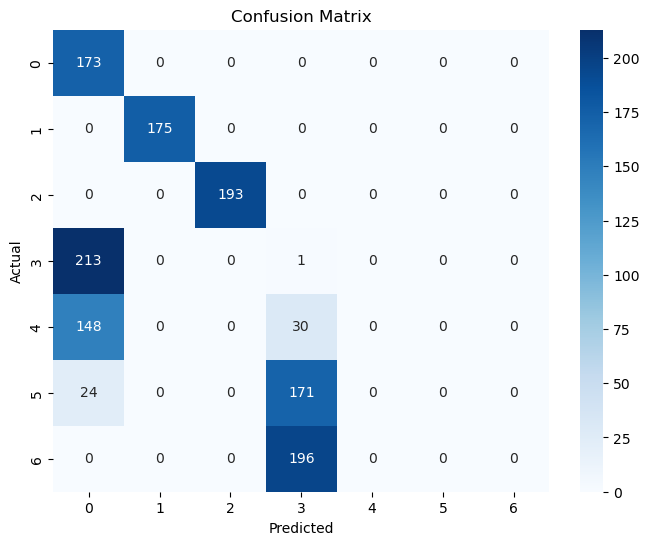


Online Adaptation Cycle 3/3

Evaluation After Online Adaptation Cycle:


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Metrics:
Accuracy: 0.41
Precision: 0.30
Recall: 0.41
F1 Score: 0.32
Cohen’s Kappa: 0.32


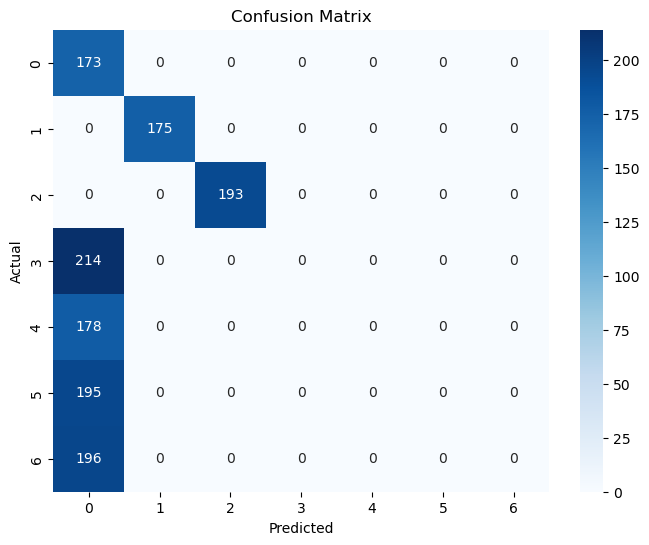


Evaluation Metrics:
Accuracy: 0.41
Precision: 0.30
Recall: 0.41
F1 Score: 0.32
Cohen’s Kappa: 0.32


/home/tipu/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


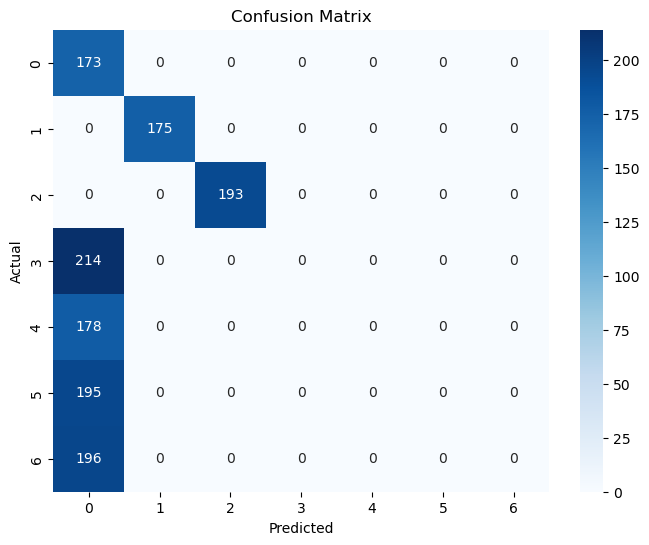


Average Metrics across 5 folds:
Precision: 0.18
Recall: 0.30
F1: 0.21
Accuracy: 0.30
Kappa: 0.19


In [4]:

for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{k}")
    X_train, X_val = data[train_index], data[val_index]
    y_train, y_val = labels[train_index], labels[val_index]
    train_dataset = EEGEMGDataset(X_train, y_train)
    val_dataset = EEGEMGDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    input_dim_eeg = eeg_data.shape[1]
    input_dim_emg = emg_data.shape[1]
    num_classes = len(np.unique(labels))

    # Select model: CNN-GRU, CNN-RNN, or TCN
    model = EEGEMGCNNGRU(input_dim_eeg=input_dim_eeg, input_dim_emg=input_dim_emg, num_classes=num_classes)
    #model = EEGEMGCNNRNN(input_dim_eeg=input_dim_eeg, input_dim_emg=input_dim_emg, num_classes=num_classes)
    #model = EEGEMGTCN(input_dim_eeg=input_dim_eeg, input_dim_emg=input_dim_emg, num_classes=num_classes)

    criterion = nn.CrossEntropyLoss()
    train_model(model, train_loader, val_loader, criterion, online_adaptation=True)
    precision, recall, f1, accuracy, kappa = evaluate_model(model, val_loader)
    fold_results.append({'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy, 'kappa': kappa})

# Average metrics
average_metrics = {metric: np.mean([result[metric] for result in fold_results]) for metric in fold_results[0]}
print(f"\nAverage Metrics across {k} folds:")
for metric, value in average_metrics.items():
    print(f"{metric.capitalize()}: {value:.2f}")